In [1]:
from salad.search import Search
from salad.directions import SearchDirections
from salad.hough import Hough
from salad.project import project
from salad.analysis.plot import plot_result, plot_cluster
from salad.cluster import Clusters, Cluster
from salad.regression import regression
from salad.gather import gather
from salad.refine import refine
from salad.cluster.filter import filter_n, filter_velocity
import pickle
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

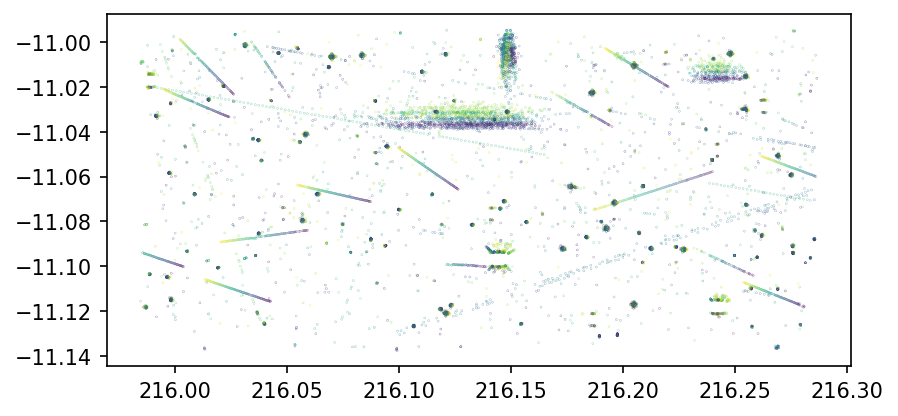

In [2]:
with open("../search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_5.0/catalog.pkl", "rb") as fd:
    catalog = pickle.load(fd)

X = catalog.X(columns=['ra', 'dec', 'time', 'exposures'])
fig = plt.figure(dpi=150)
ax = plt.subplot()
ax.set_aspect("equal")
cbar = ax.scatter(X[:, 0], X[:, 1], c=X[:, 2], s=0.01)
# fig.colorbar(cbar, ax=ax)
plt.show()

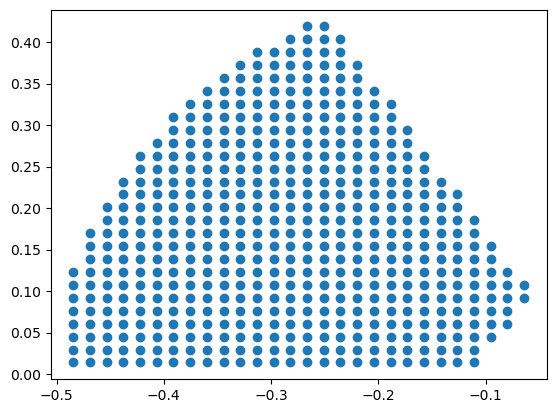

In [3]:
# %%time
dt = (max(catalog.time) - min(catalog.time))*u.day
reference_time = min(catalog.time) * u.day
v_range, phi_range, dx = (0.1*u.deg/u.day, 0.5*u.deg/u.day), (120*u.deg, 240*u.deg), 10*u.arcsec

b = SearchDirections(v_range, phi_range, dx, dt)
plt.scatter(b.b[:, 0], b.b[:, 1])
plt.show()

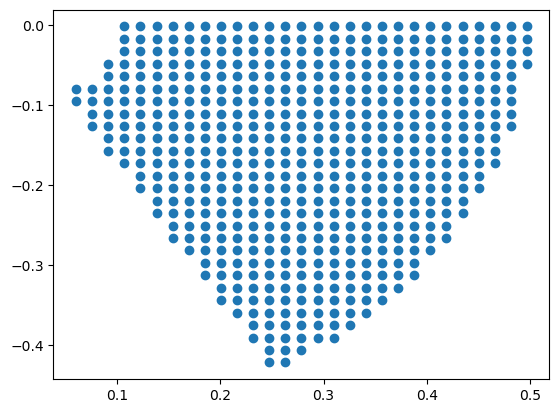

In [3]:
# %%time
dt = (max(catalog.time) - min(catalog.time))*u.day
reference_time = min(catalog.time) * u.day
v_range, phi_range, dx = (0.1*u.deg/u.day, 0.5*u.deg/u.day), (-60*u.deg, 0*u.deg), 10*u.arcsec

b = SearchDirections(v_range, phi_range, dx, dt)
plt.scatter(b.b[:, 0], b.b[:, 1])
plt.show()

In [4]:
%%time
projection = project(X, b, reference_time)

CPU times: user 2.78 s, sys: 320 ms, total: 3.1 s
Wall time: 3.14 s


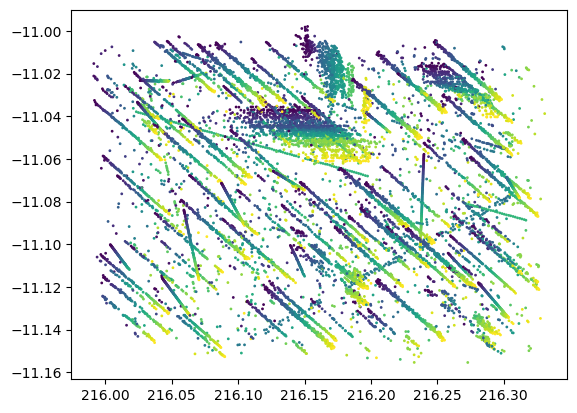

In [5]:
i = 250
plt.scatter(
    projection.projected[i, :, 0], projection.projected[i, :, 1], s=1, c=projection.X[:, 2]
)
plt.show()

In [6]:
%%time
hough = Hough(projection, dx, dx)
hough.max()

CPU times: user 2.28 s, sys: 130 ms, total: 2.41 s
Wall time: 2.41 s


109

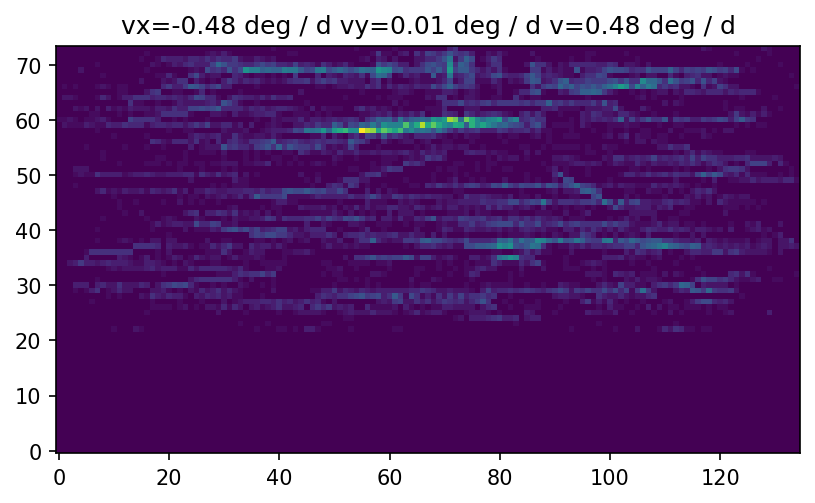

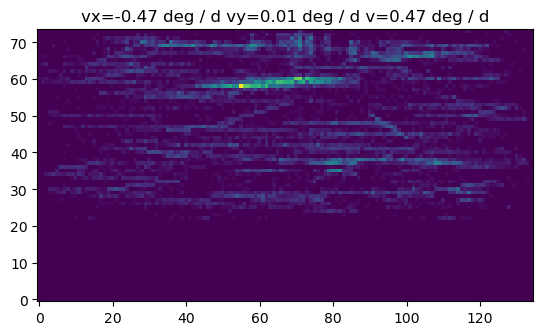

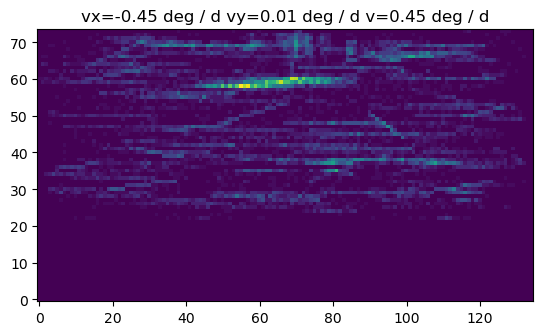

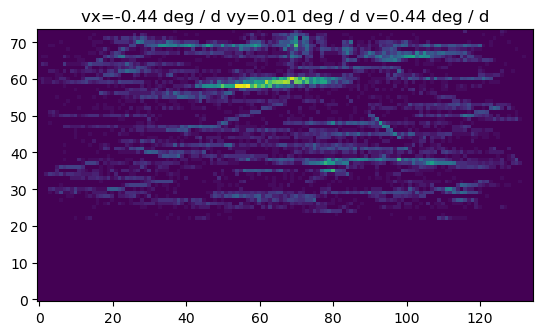

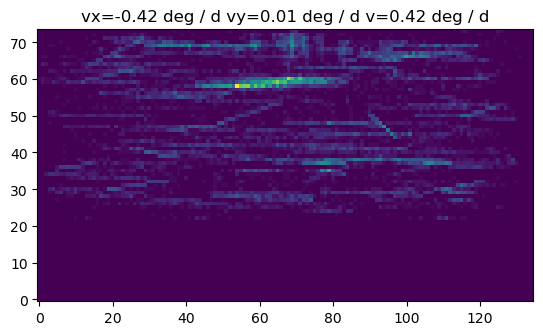

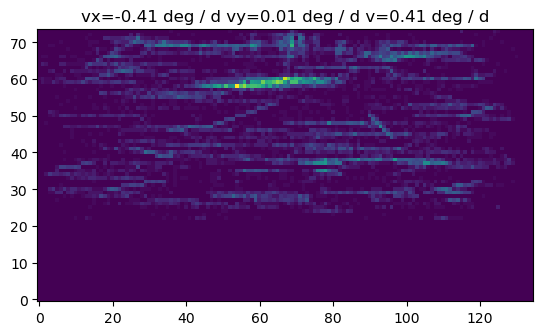

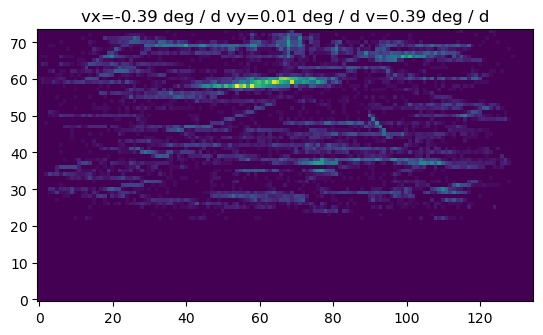

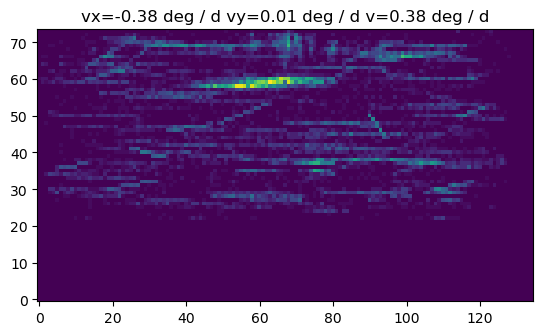

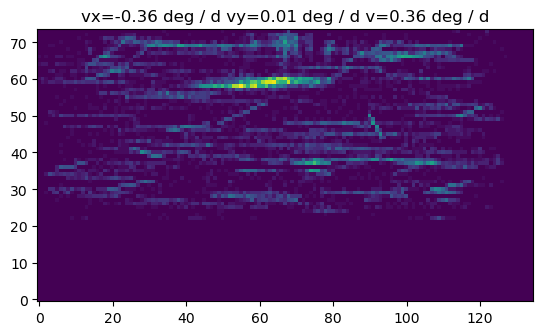

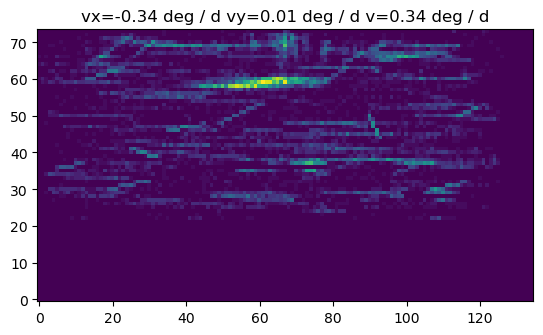

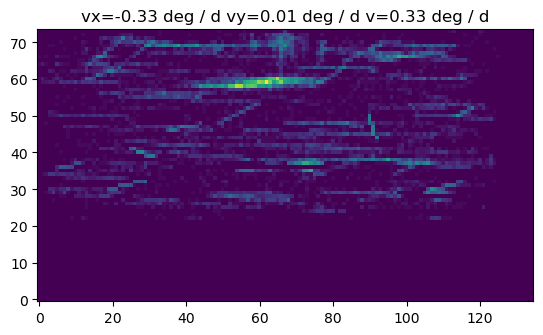

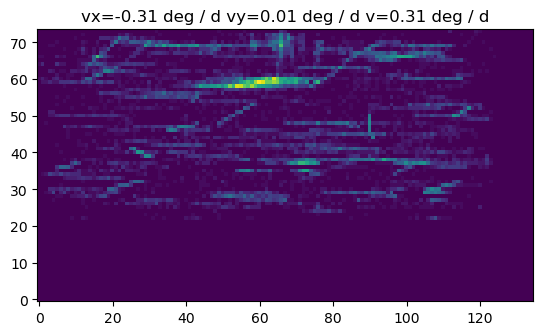

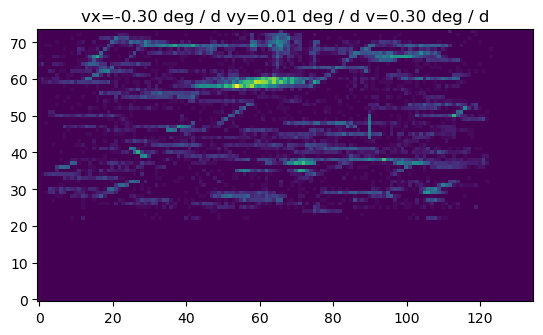

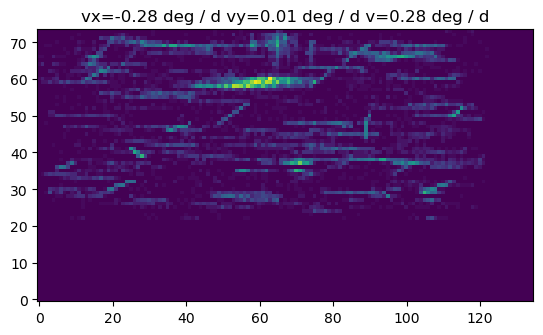

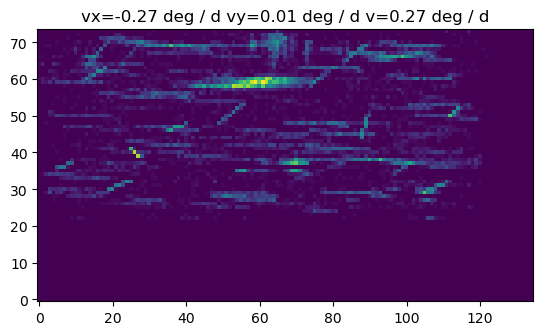

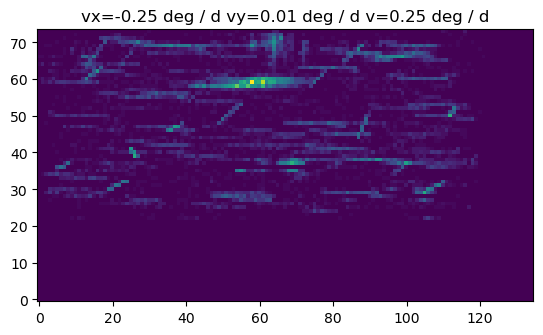

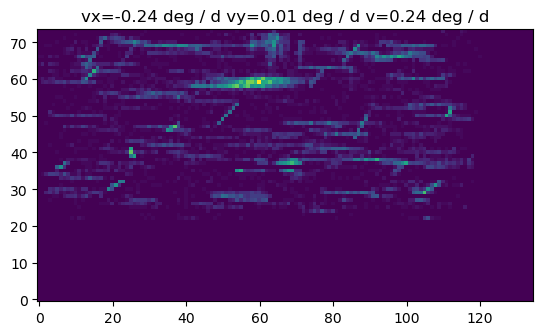

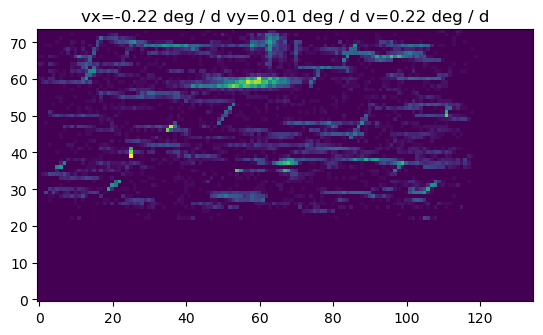

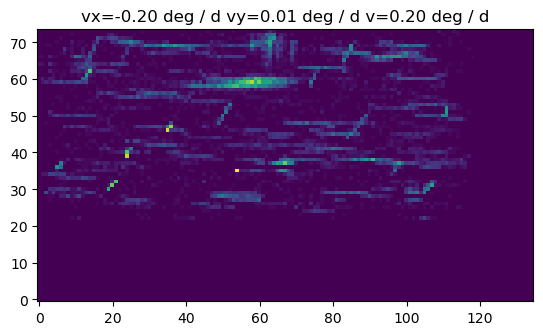

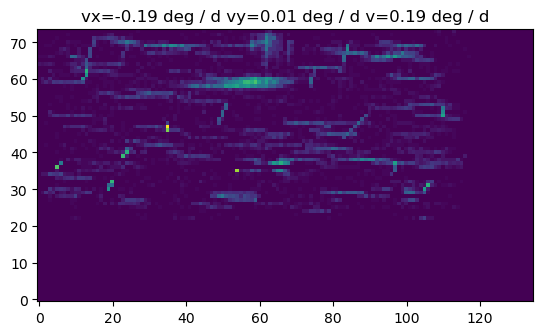

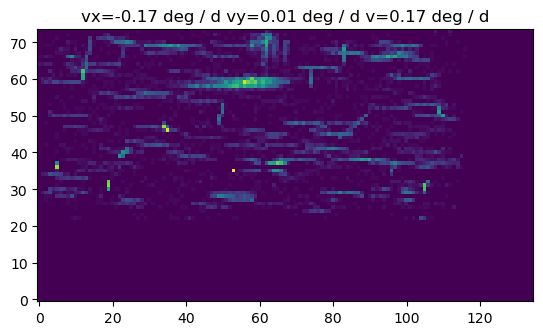

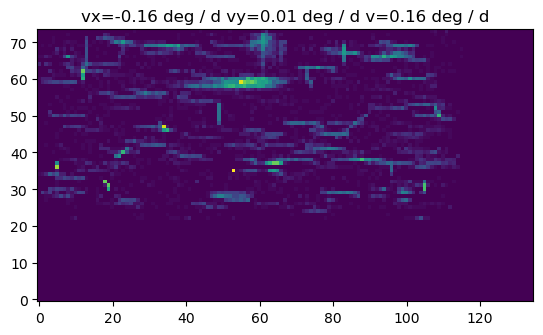

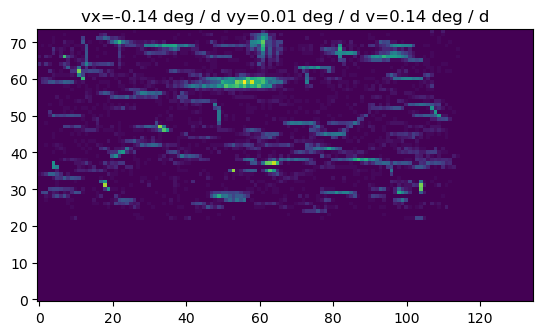

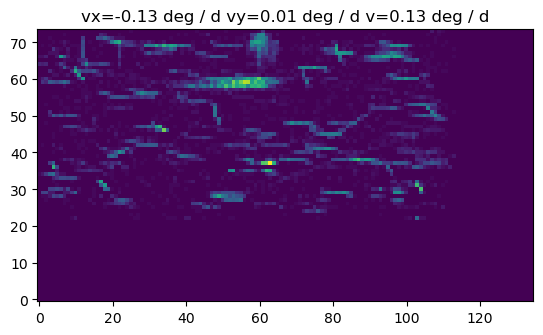

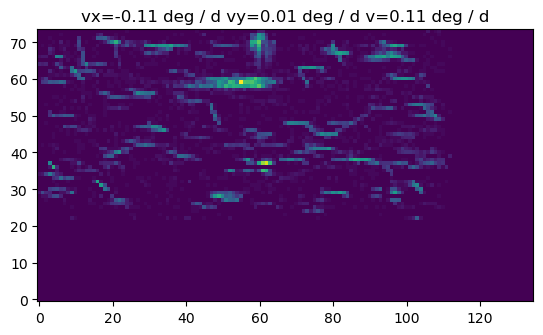

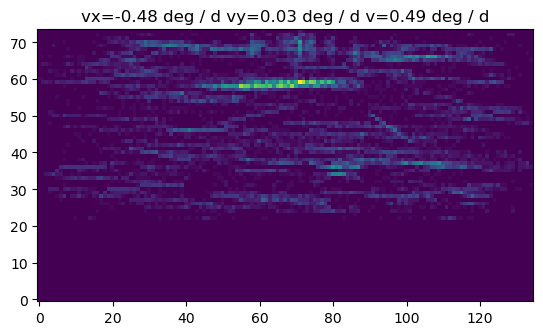

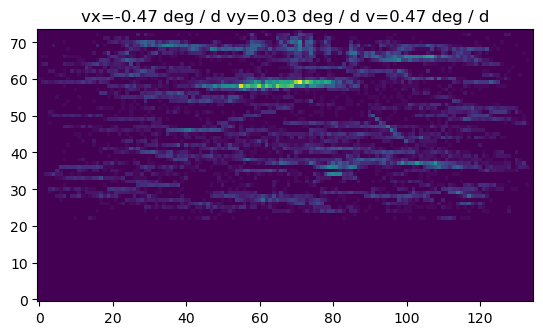

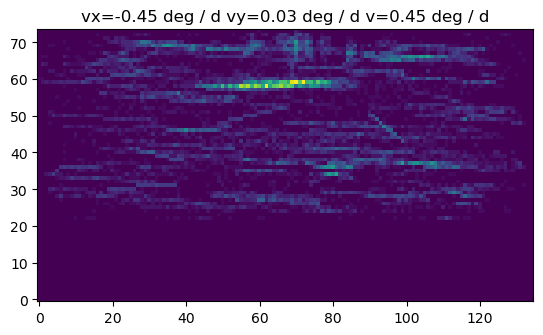

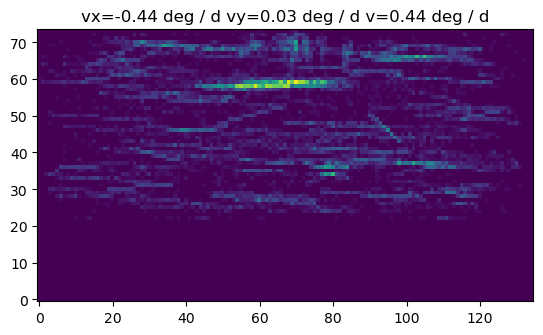

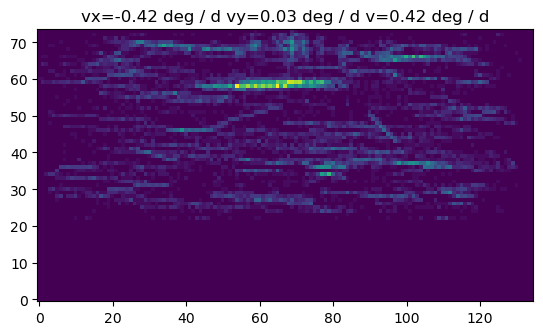

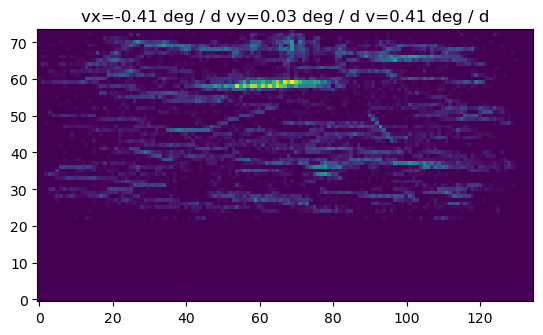

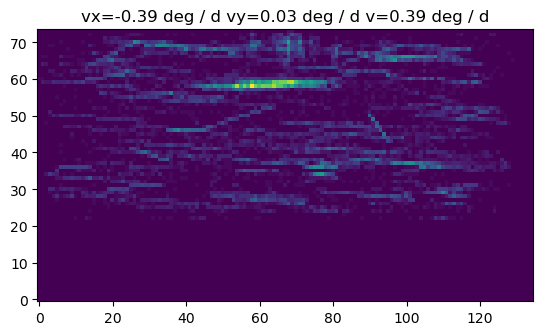

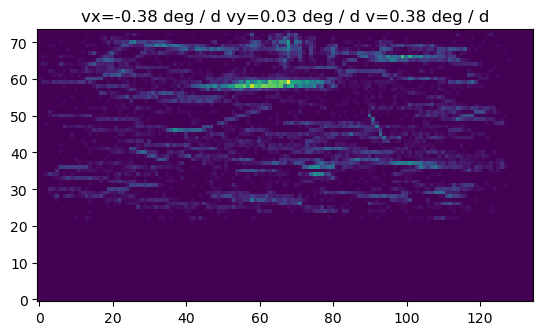

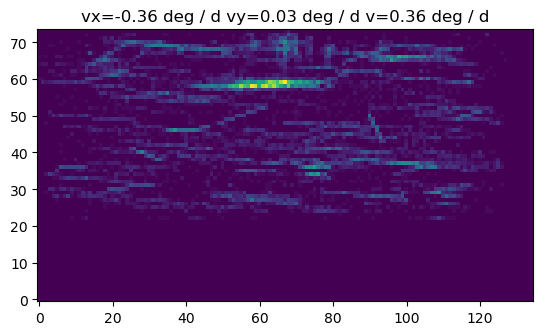

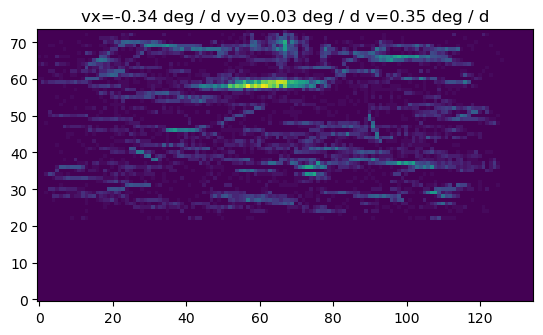

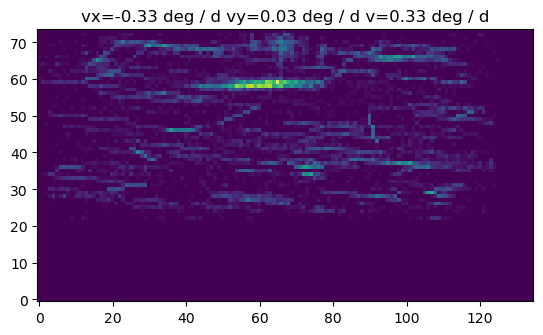

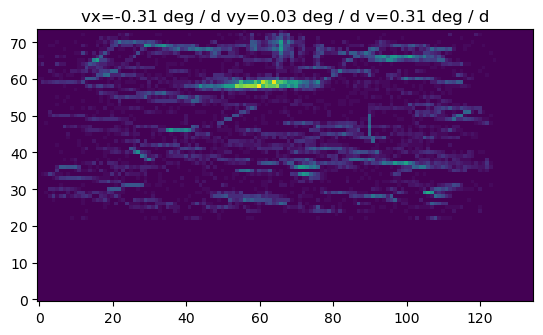

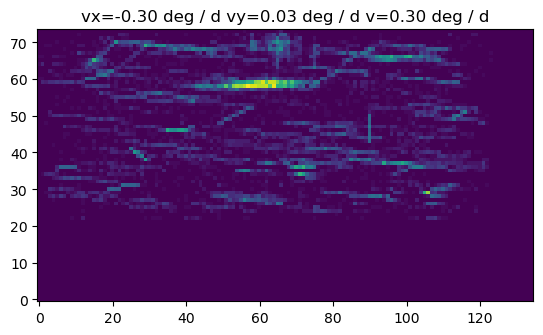

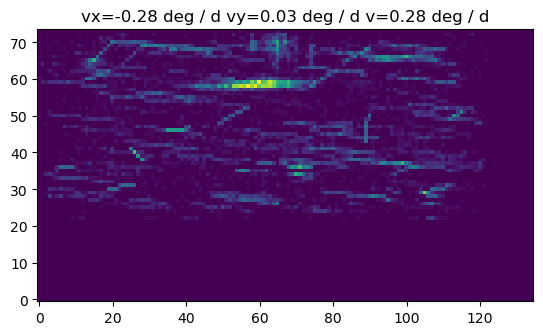

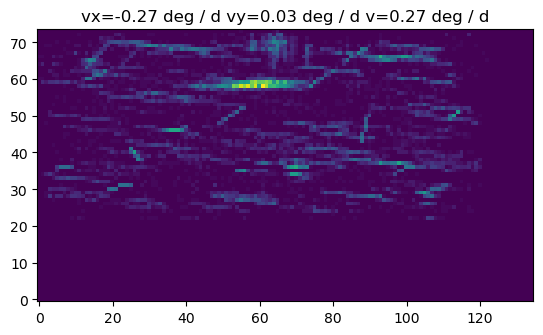

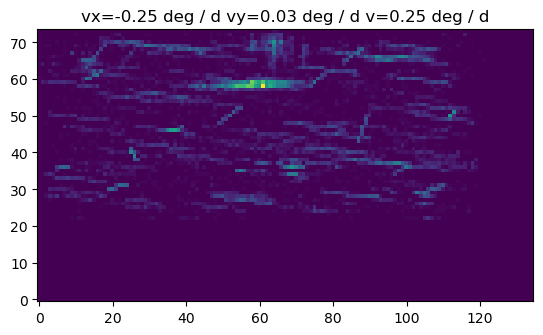

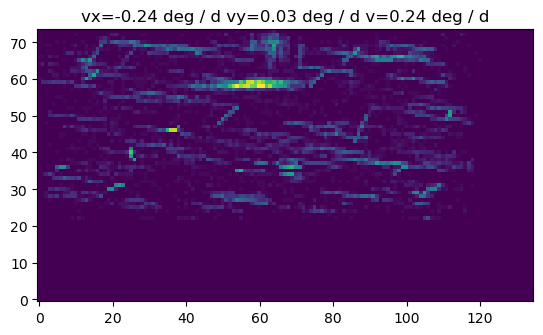

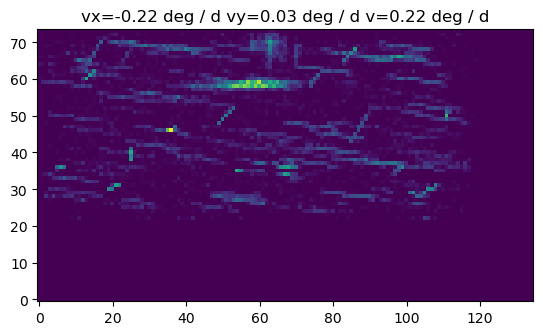

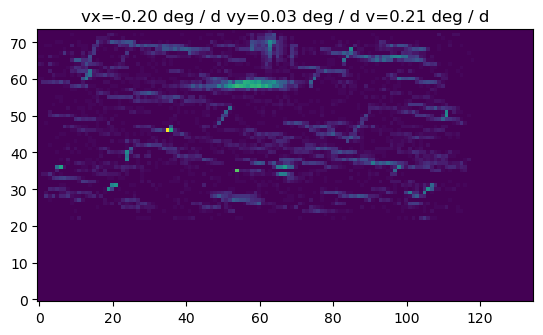

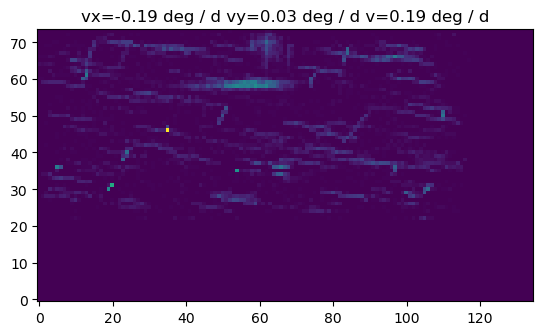

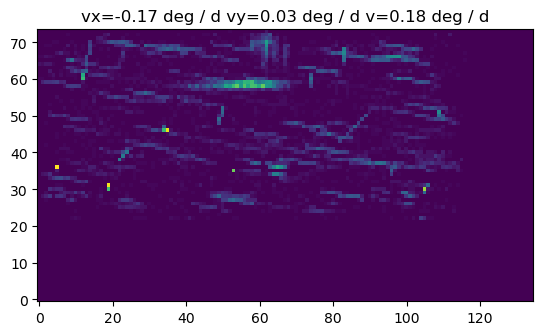

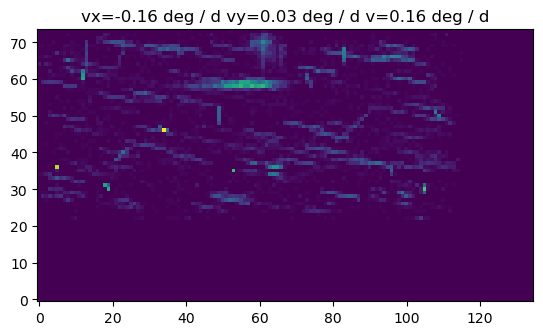

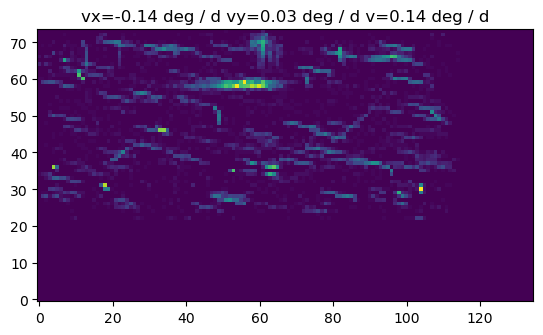

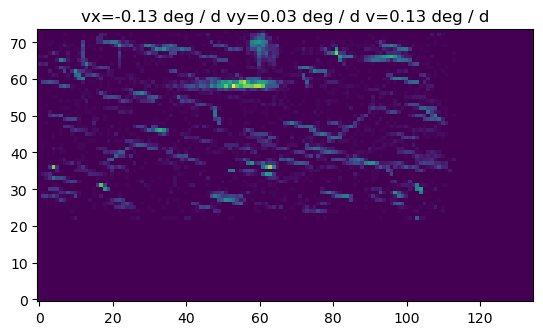

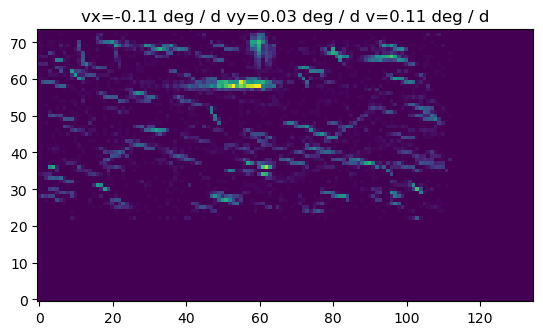

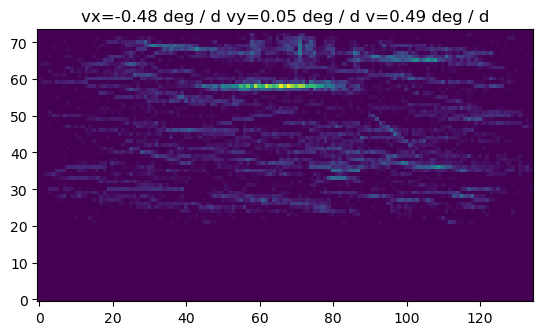

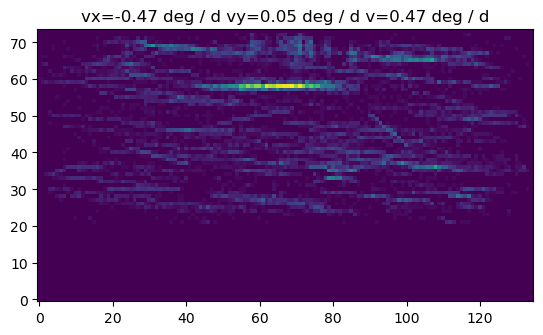

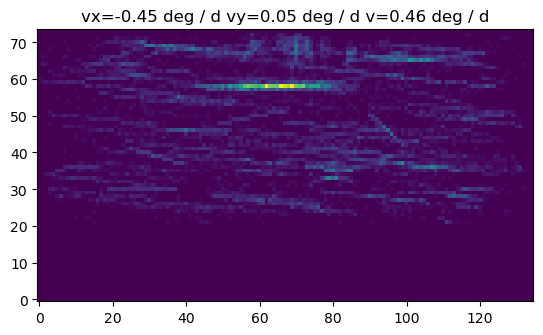

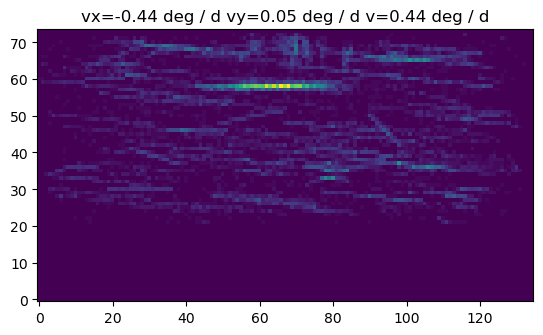

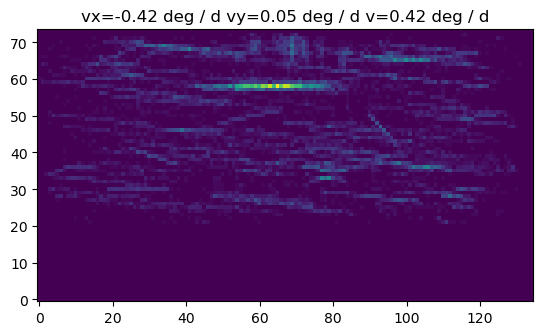

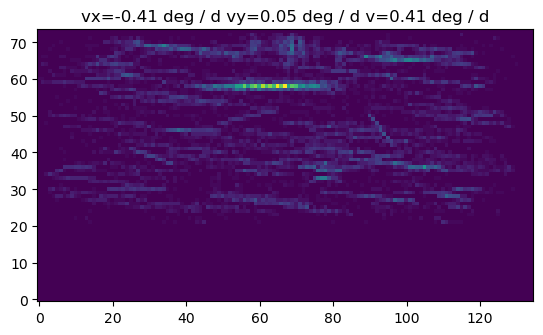

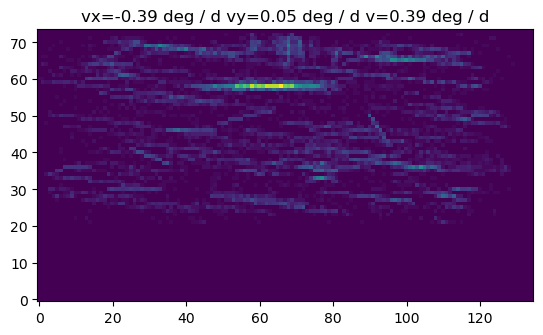

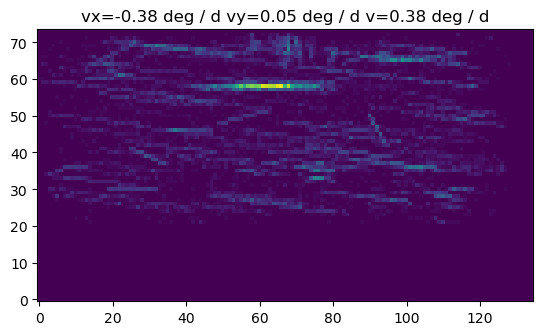

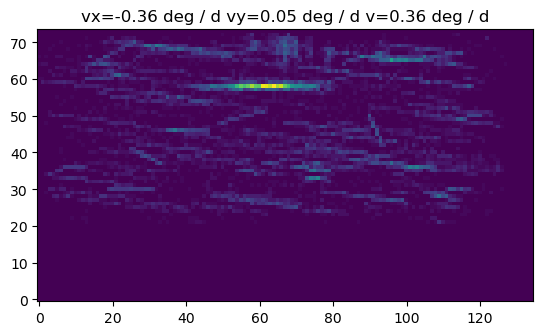

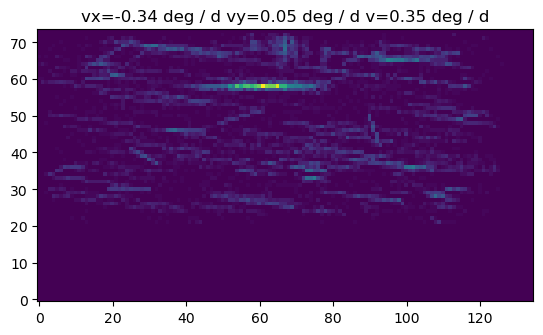

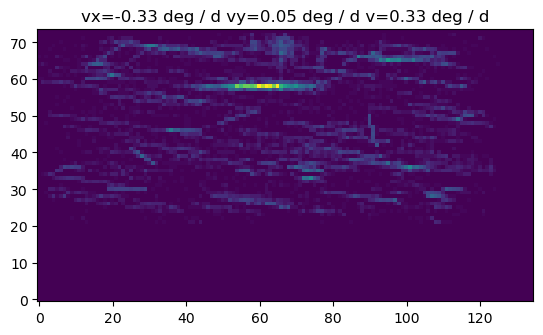

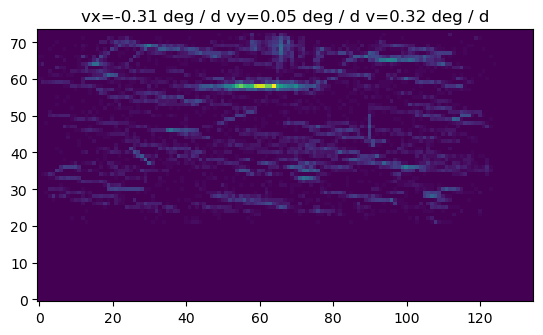

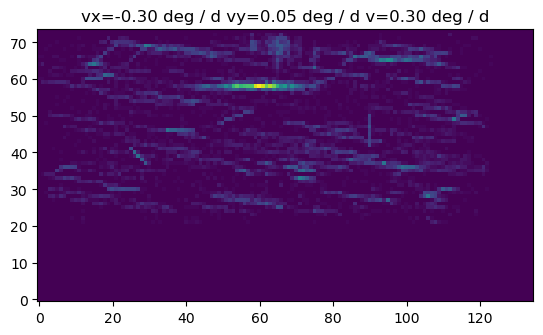

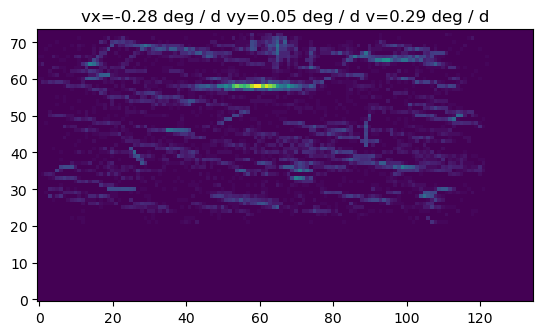

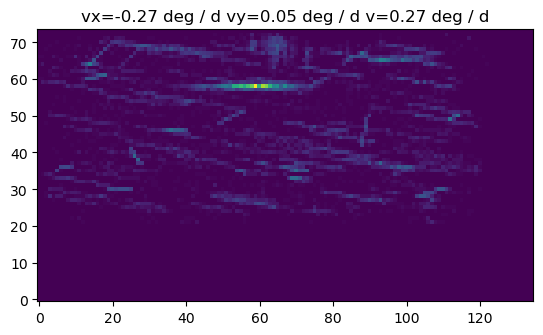

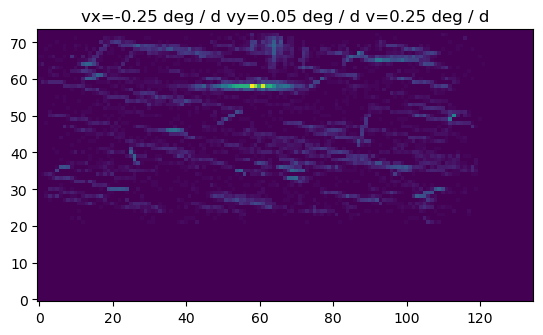

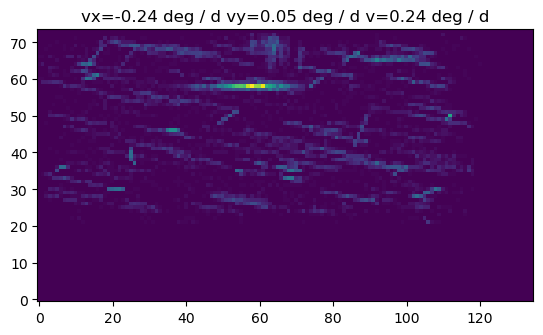

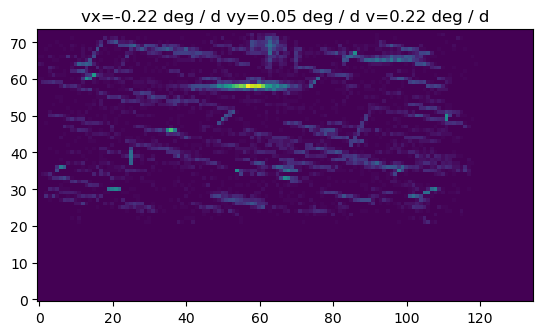

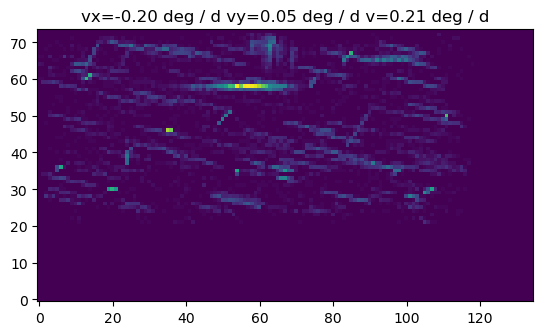

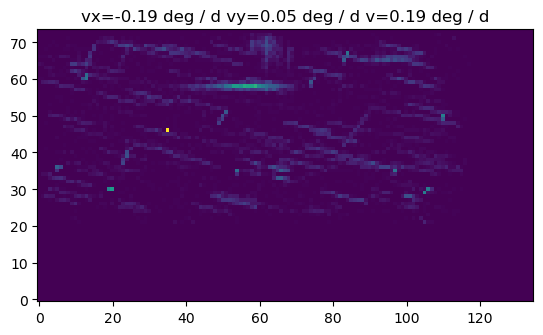

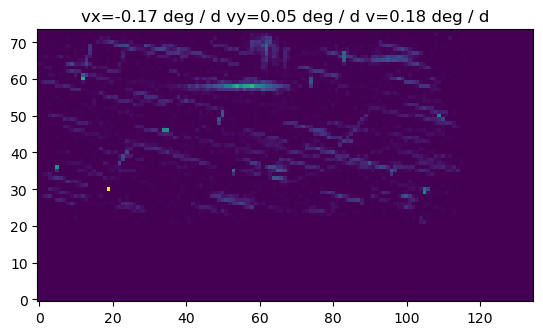

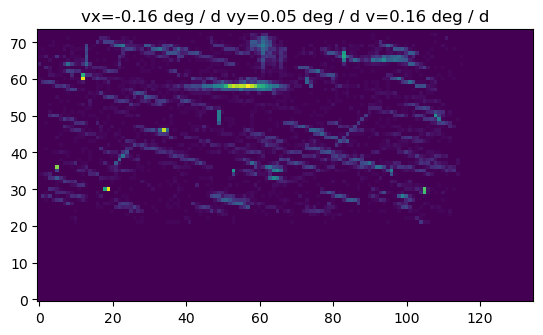

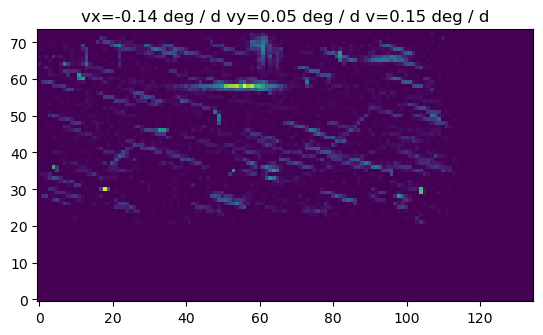

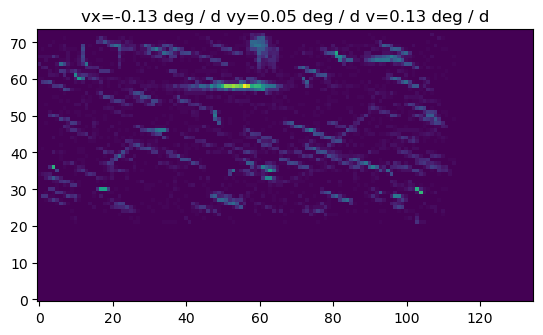

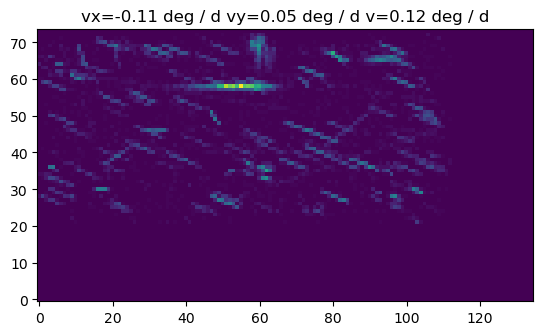

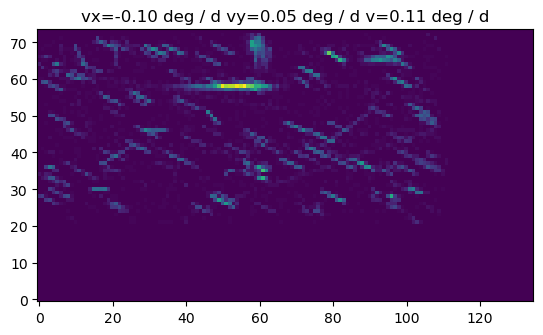

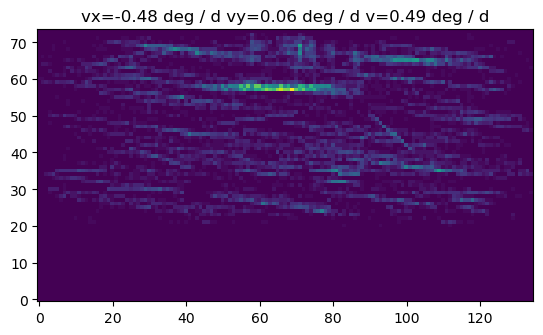

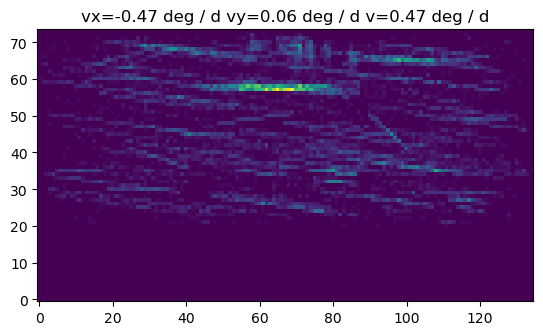

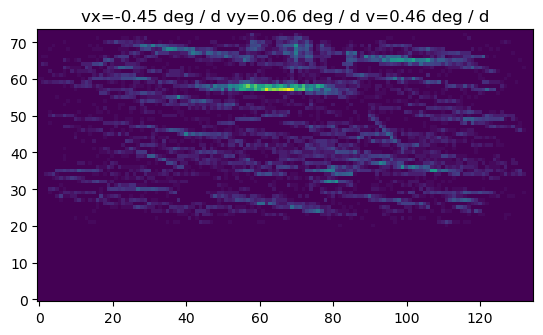

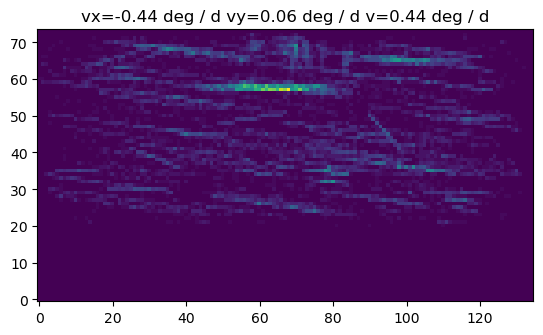

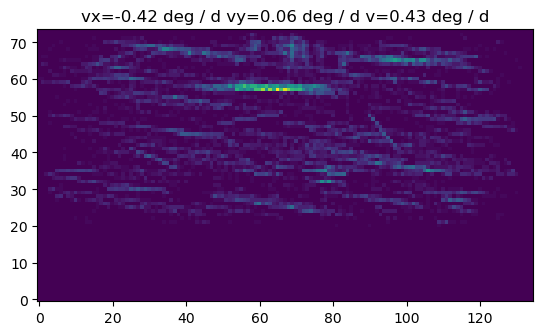

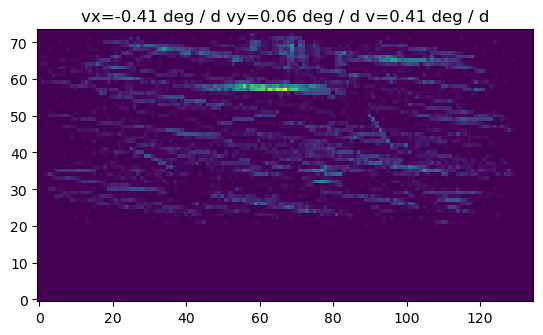

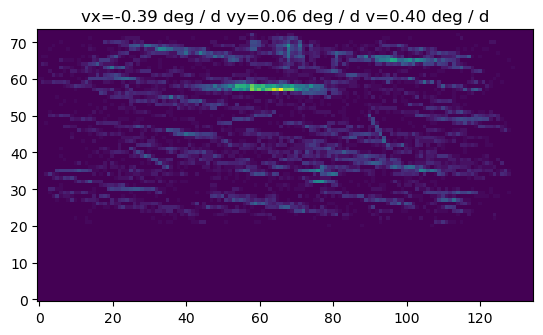

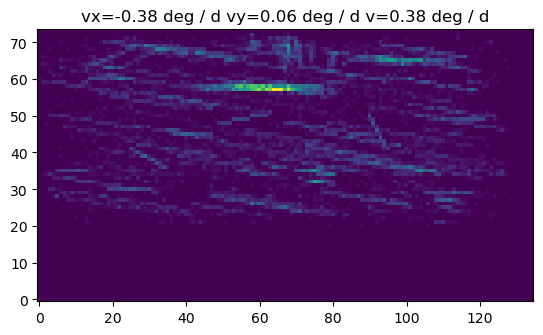

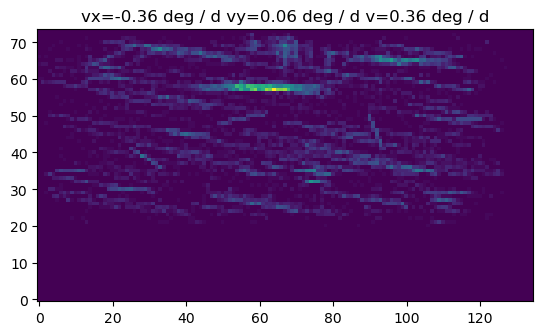

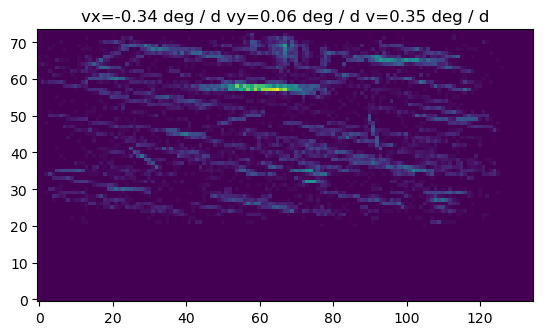

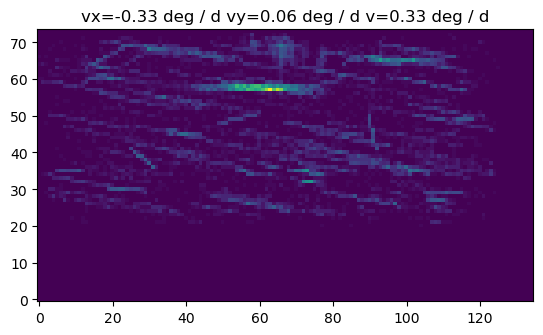

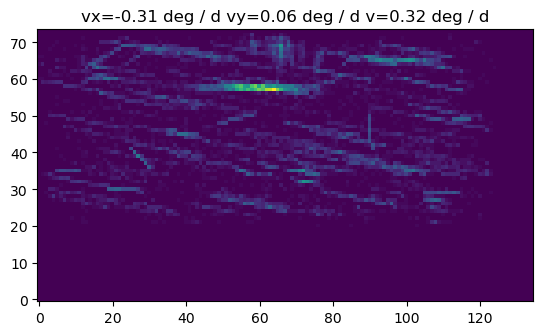

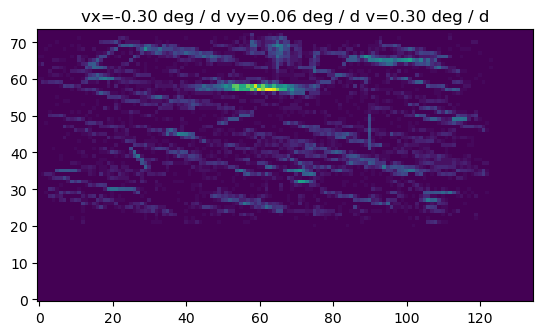

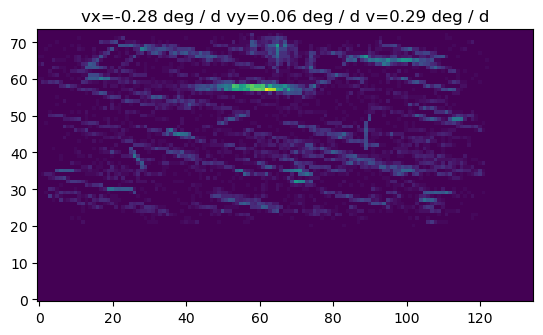

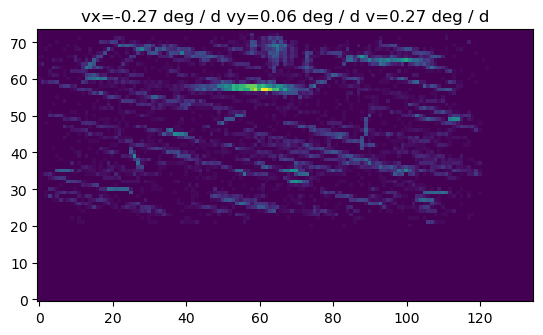

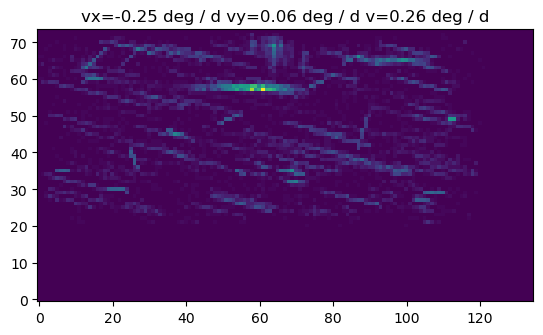

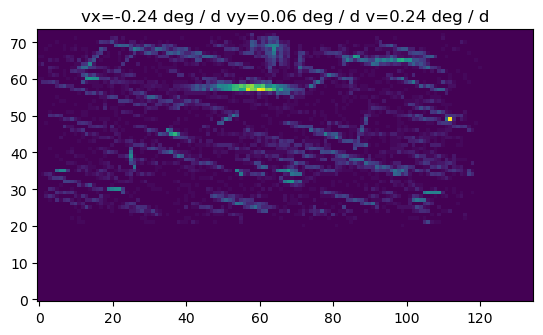

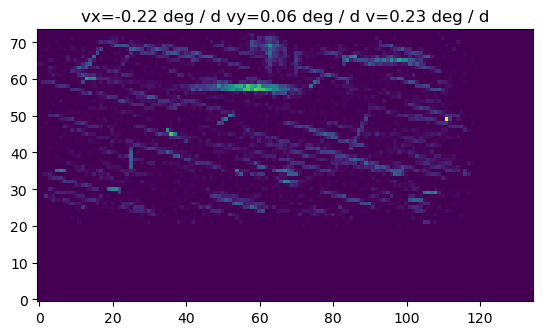

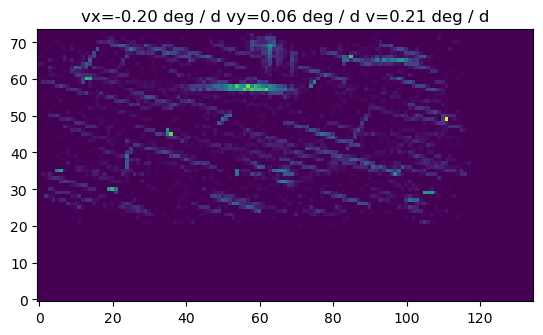

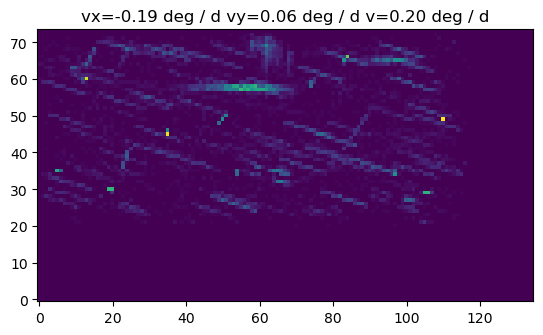

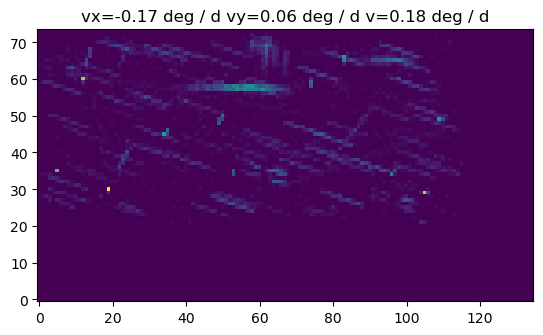

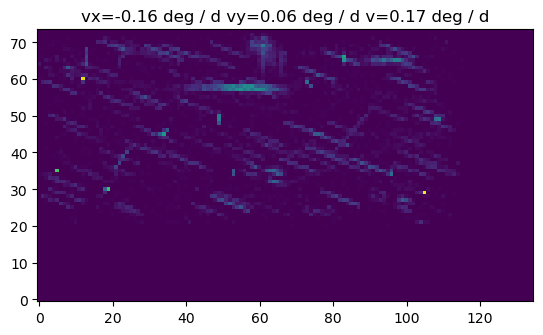

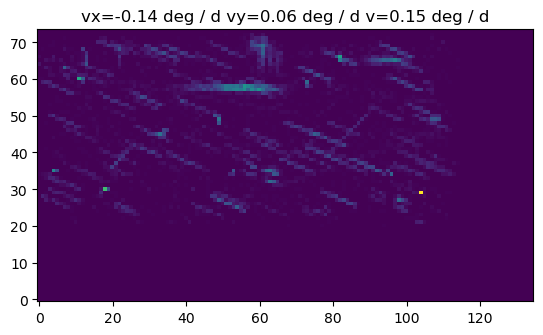

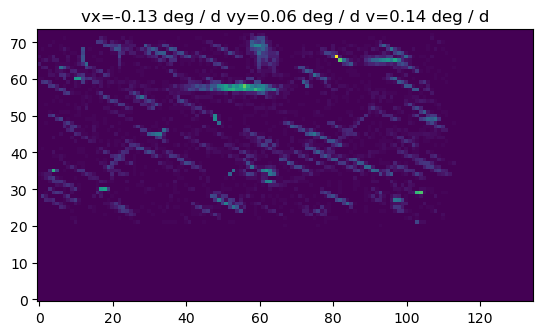

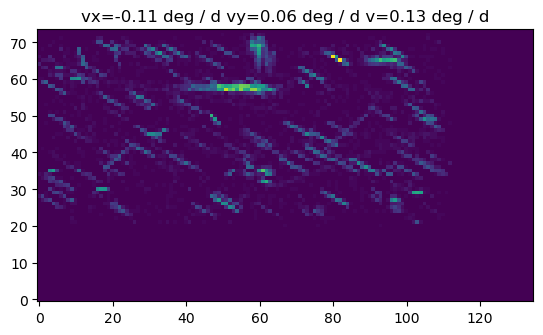

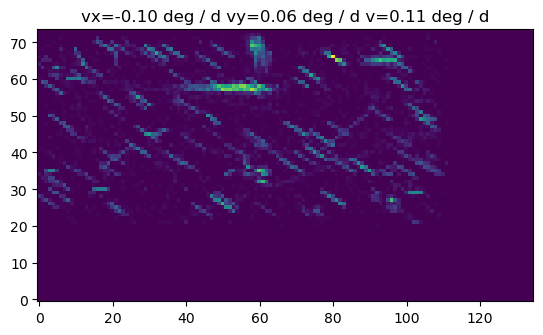

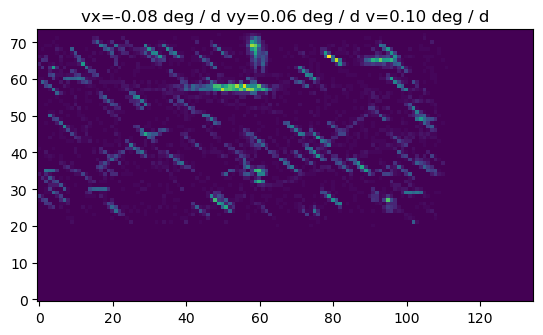

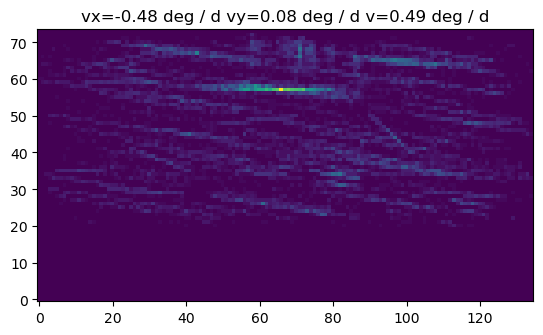

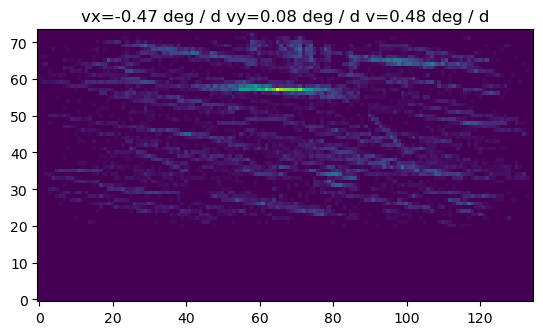

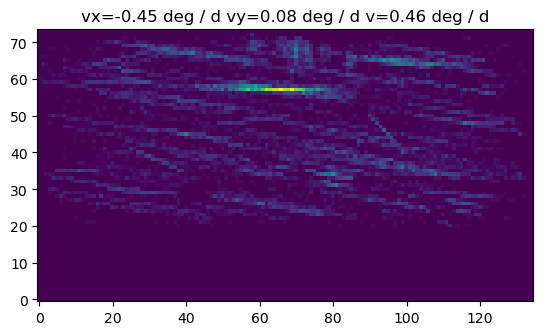

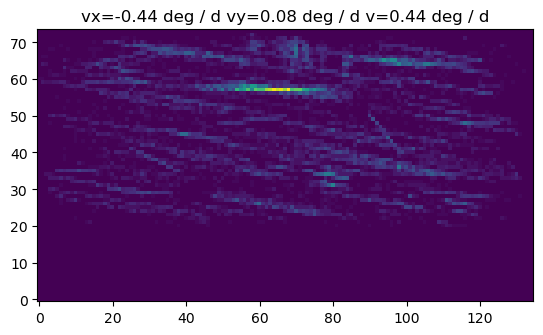

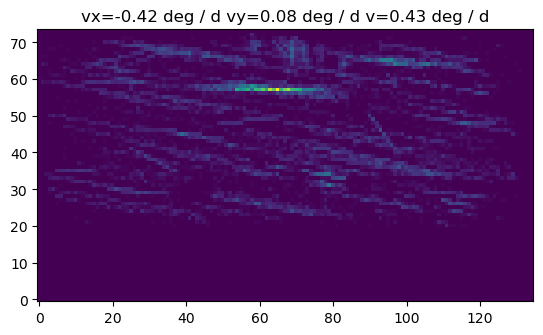

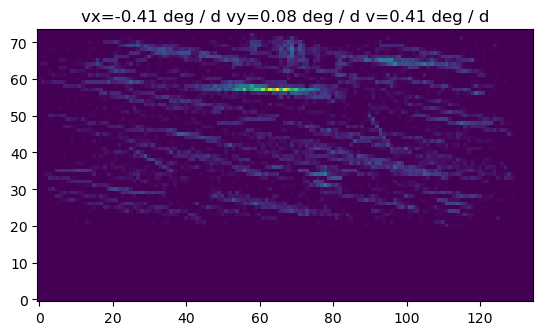

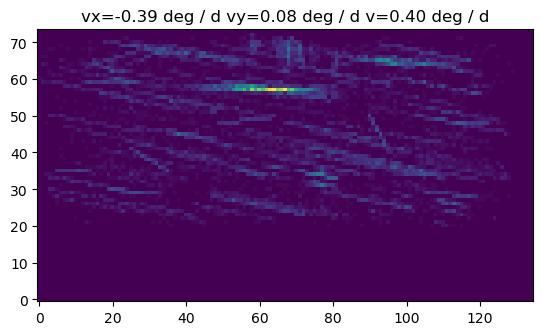

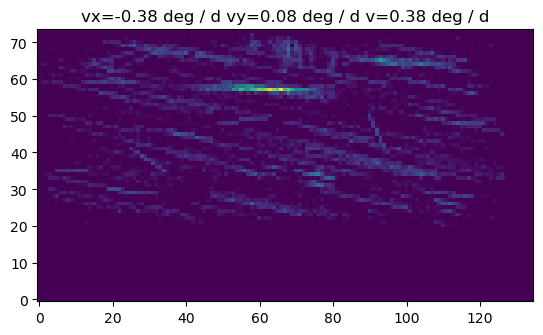

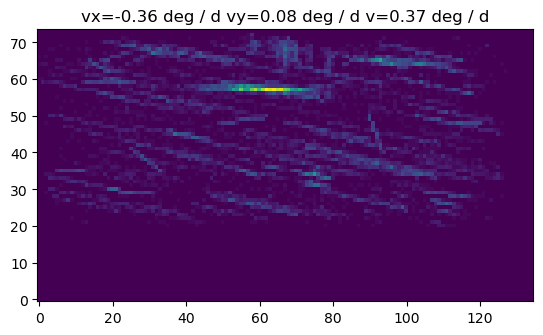

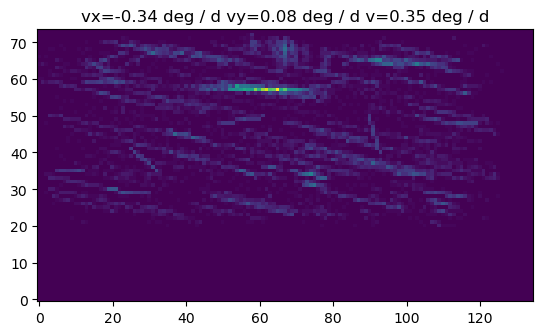

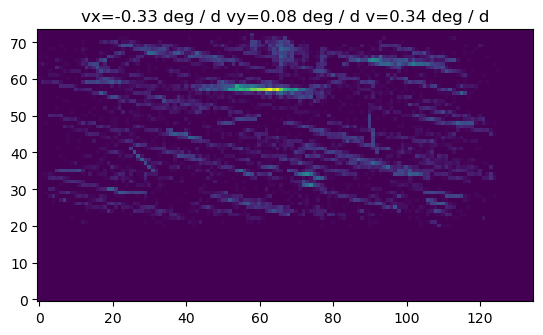

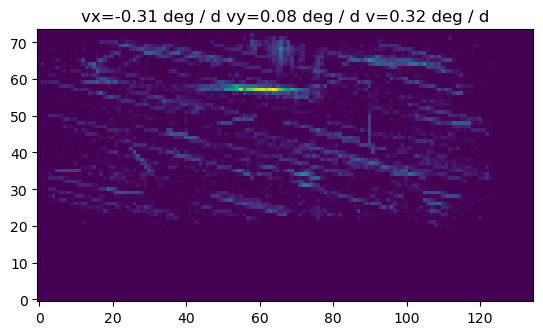

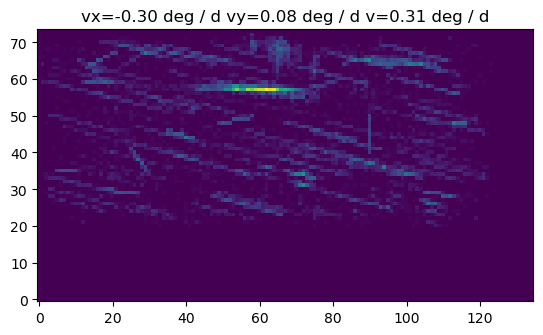

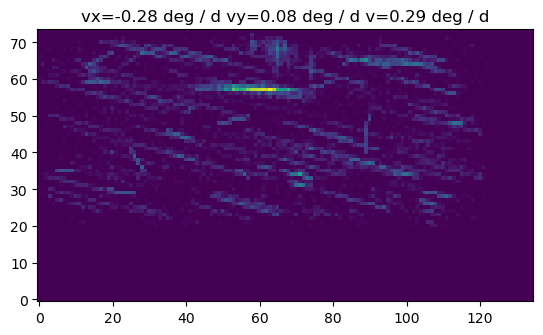

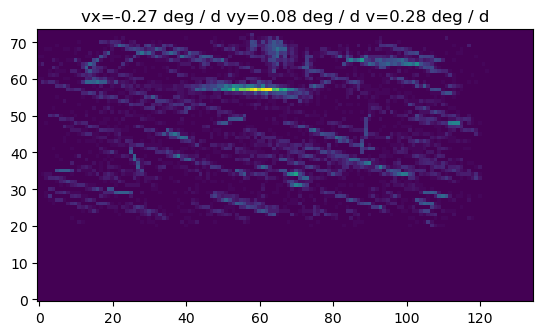

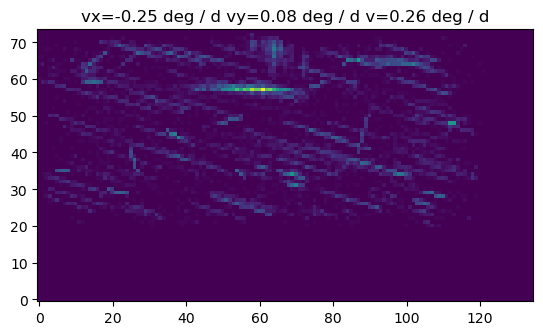

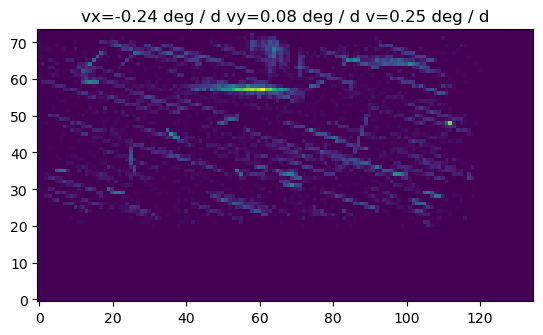

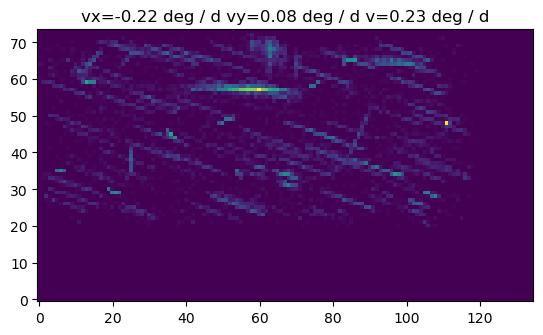

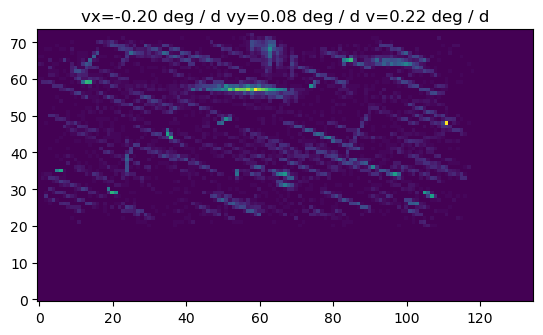

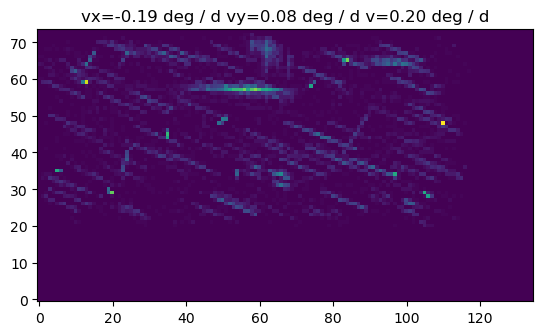

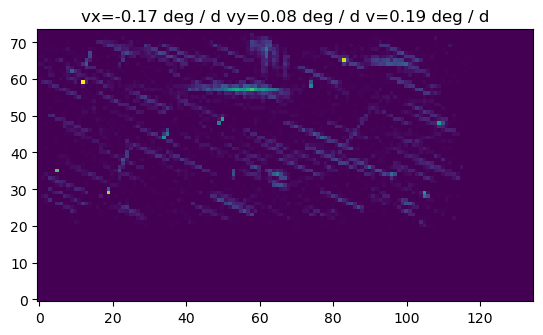

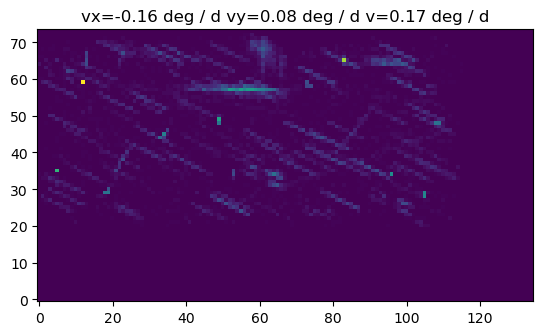

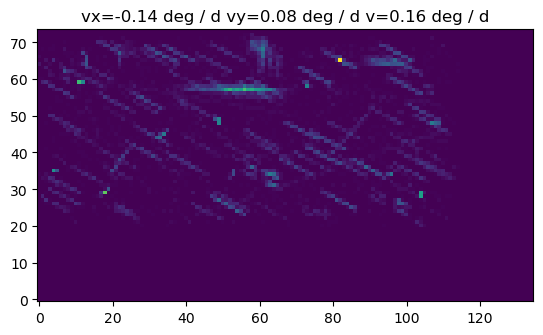

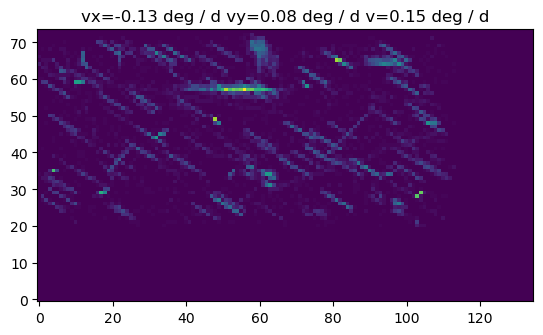

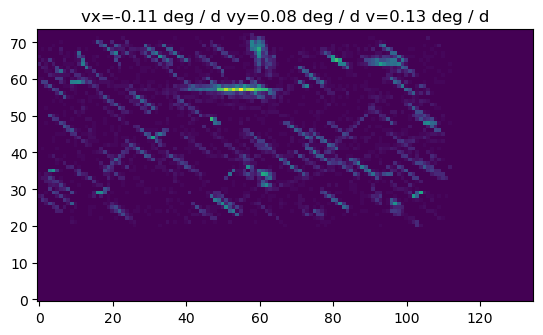

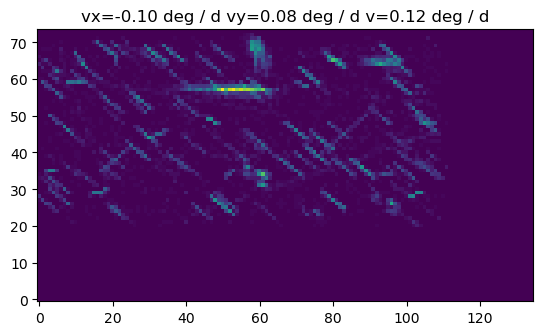

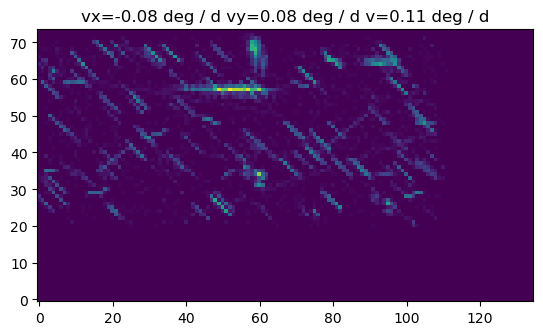

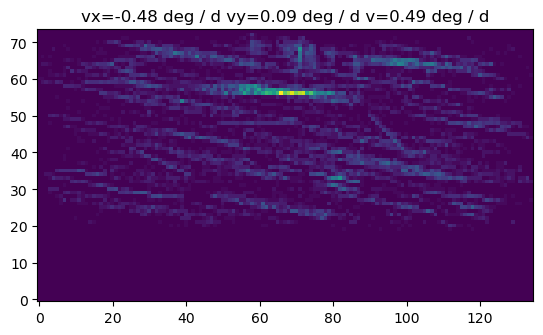

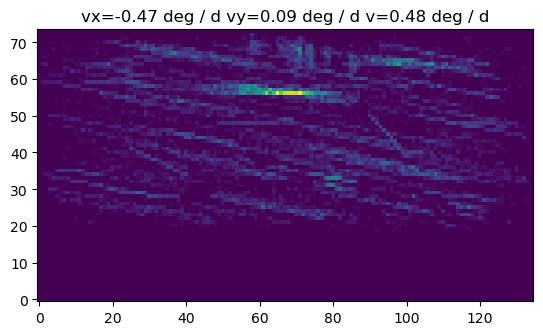

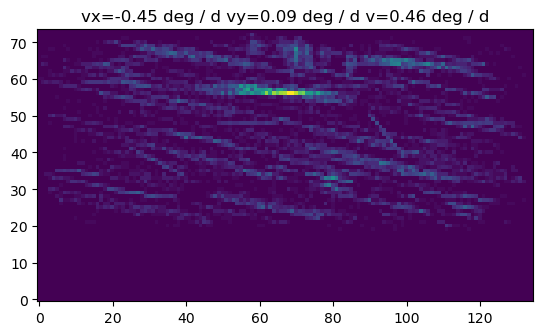

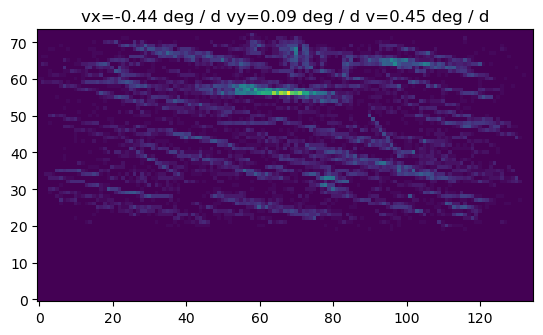

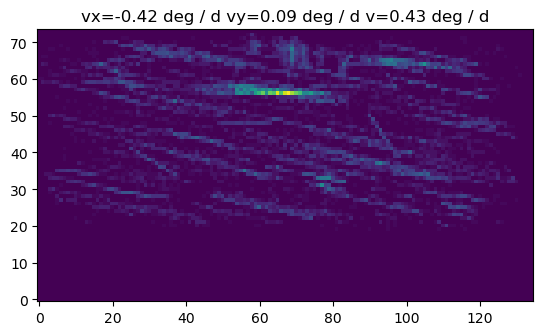

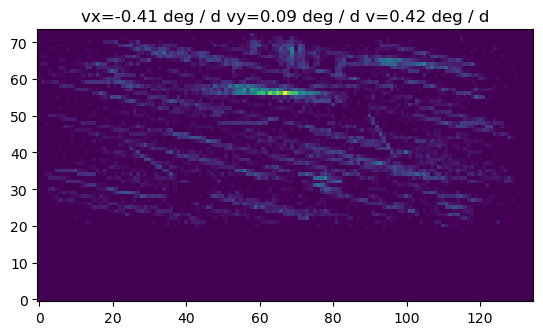

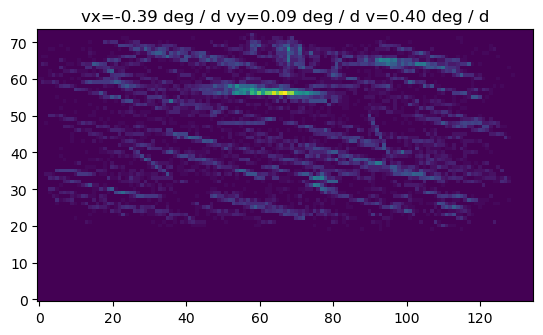

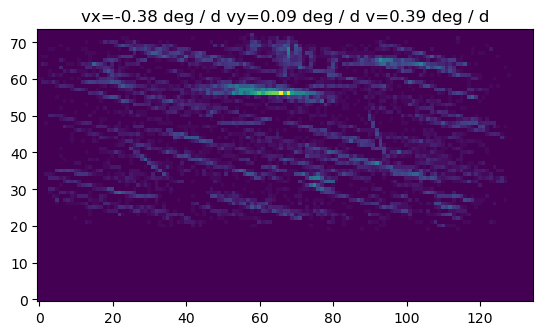

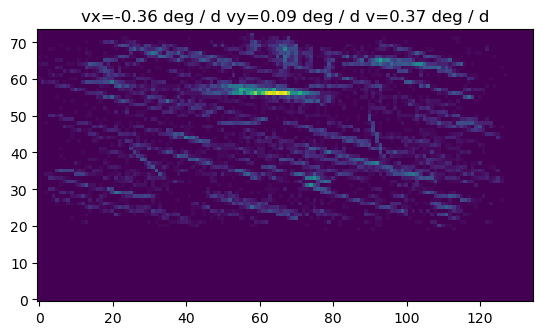

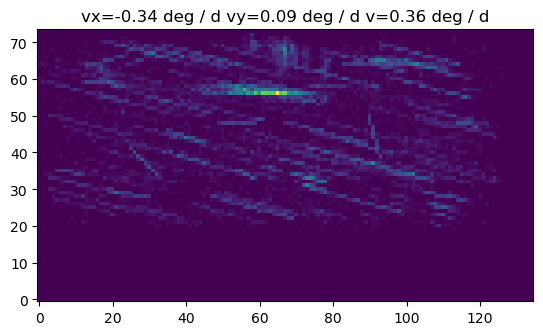

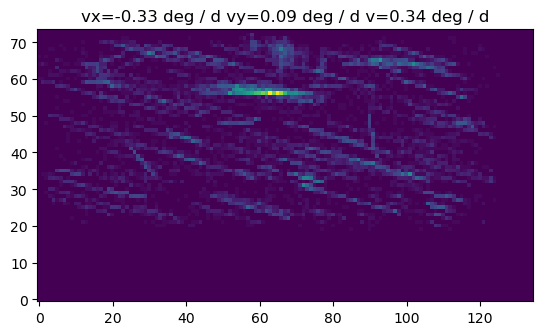

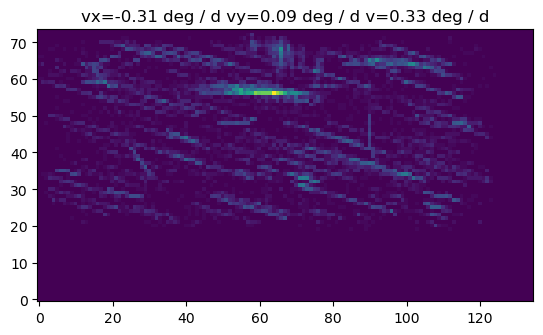

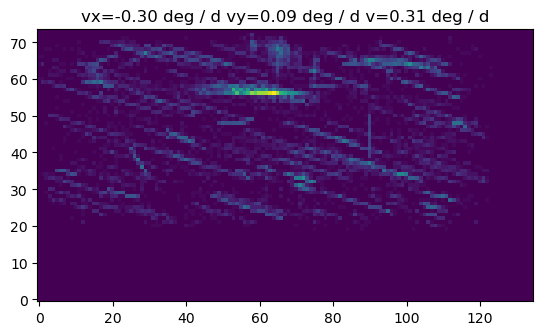

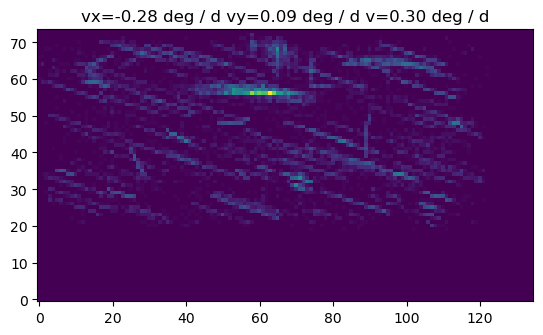

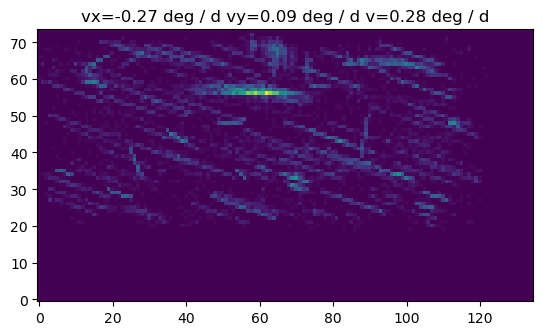

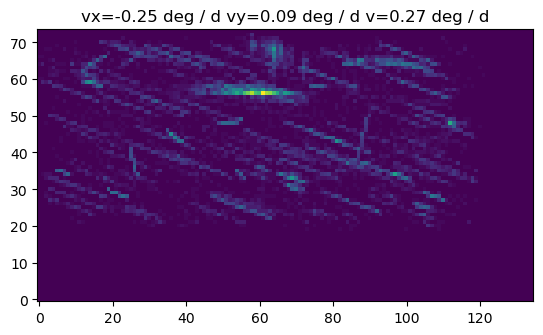

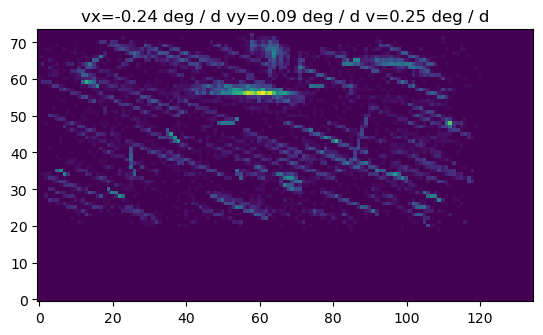

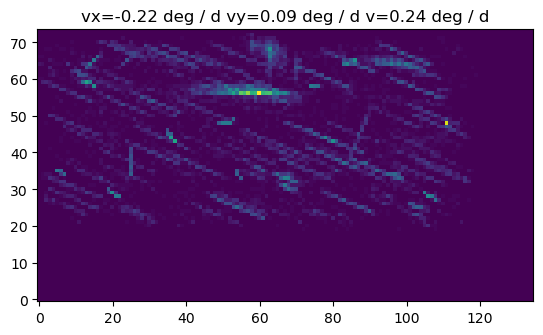

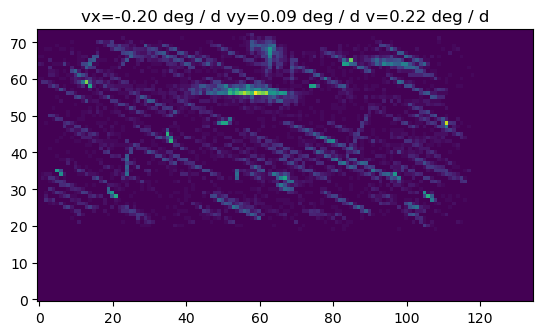

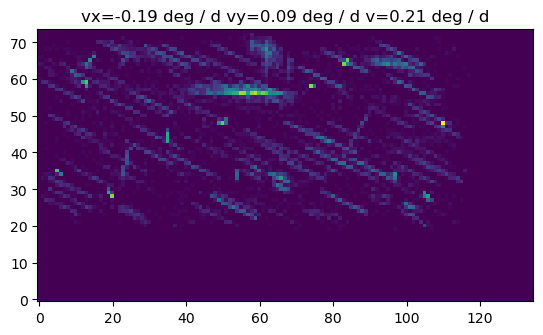

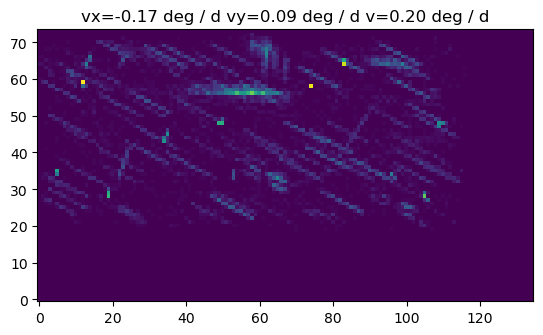

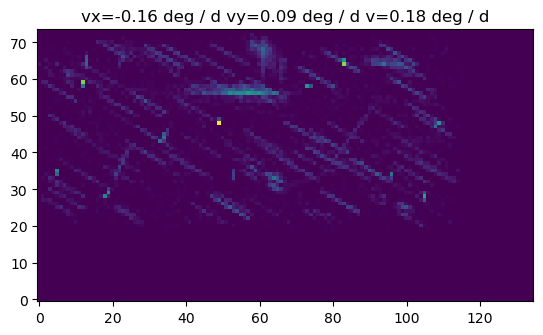

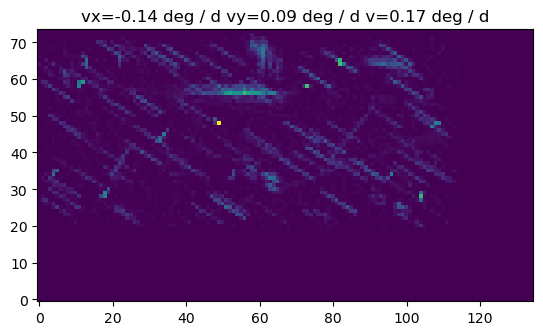

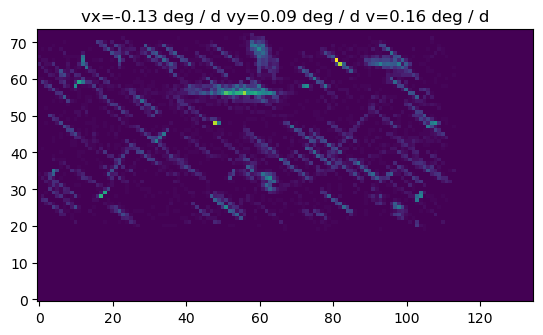

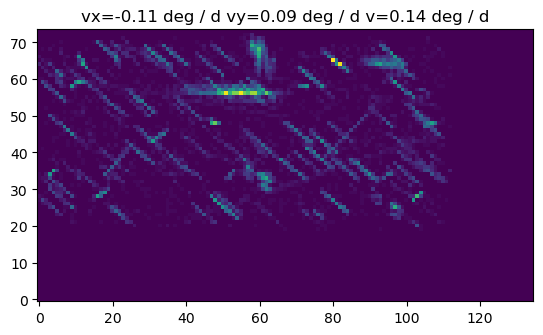

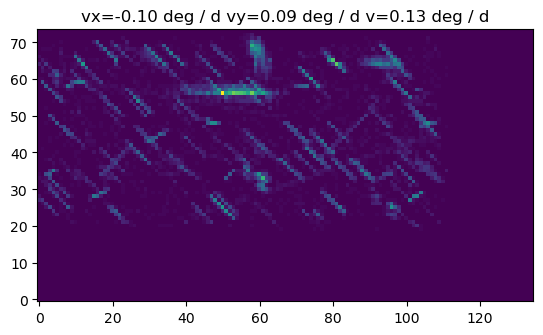

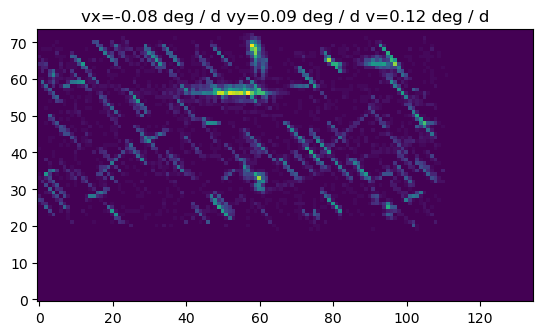

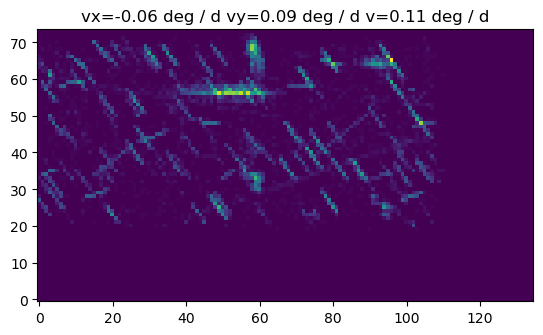

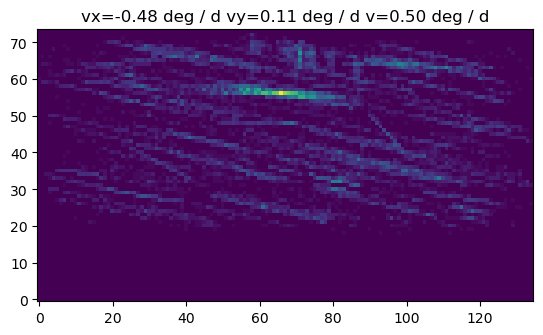

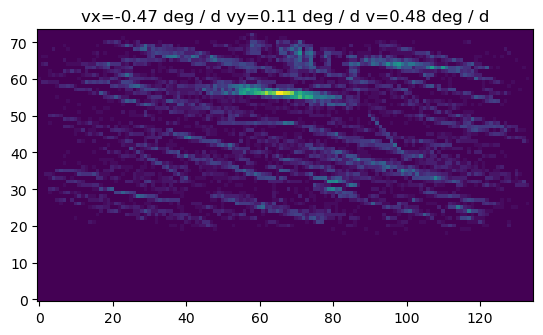

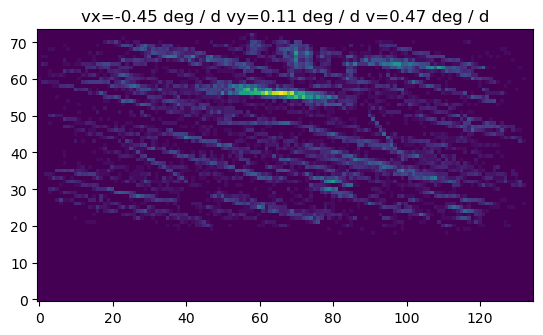

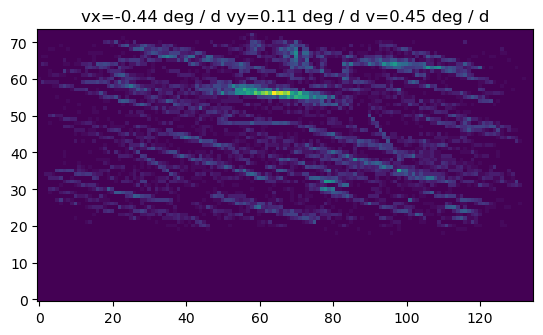

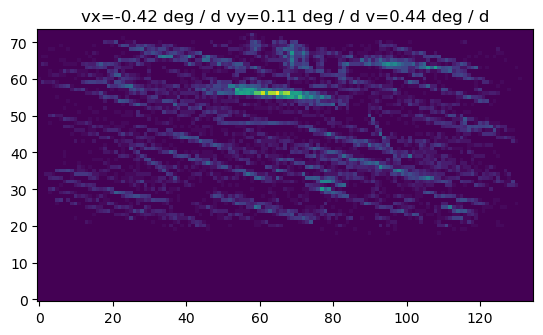

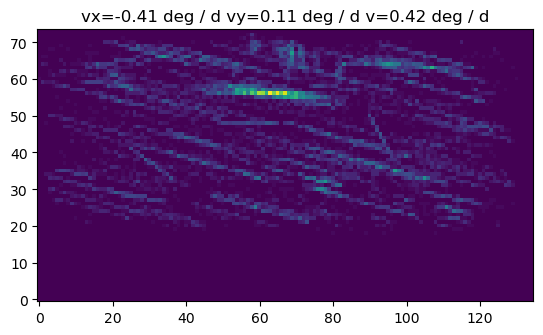

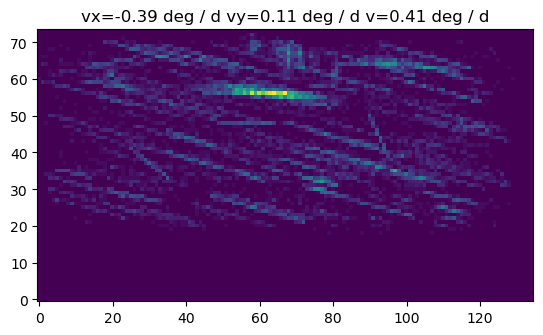

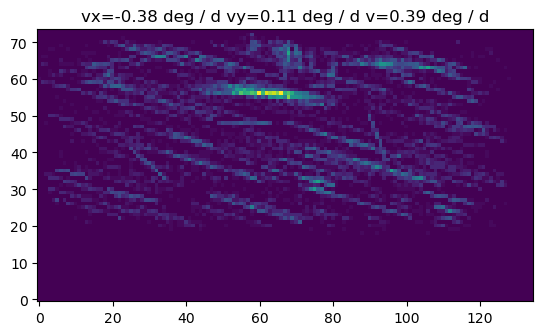

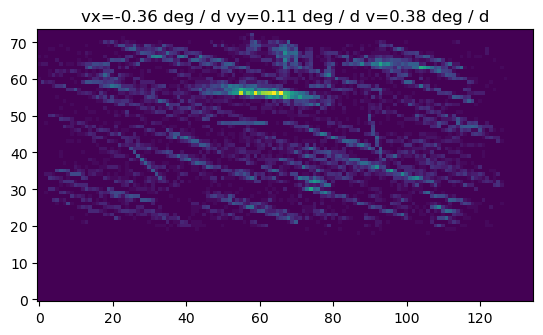

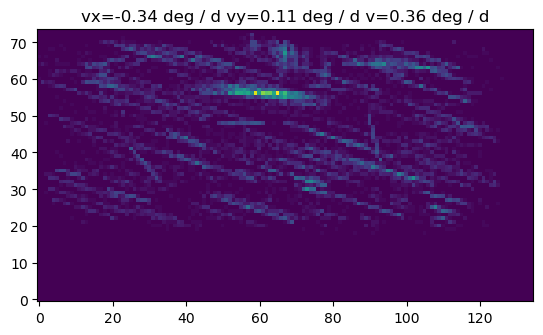

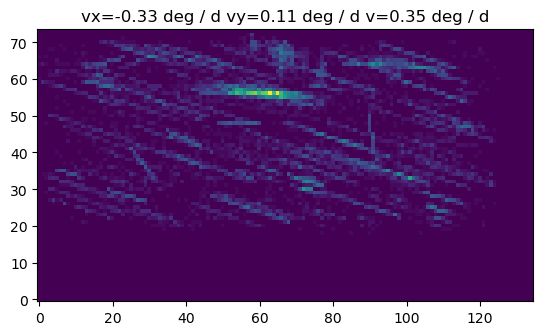

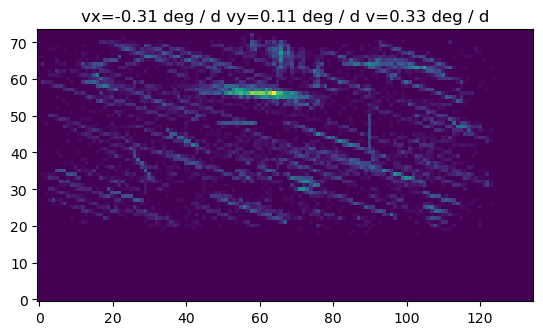

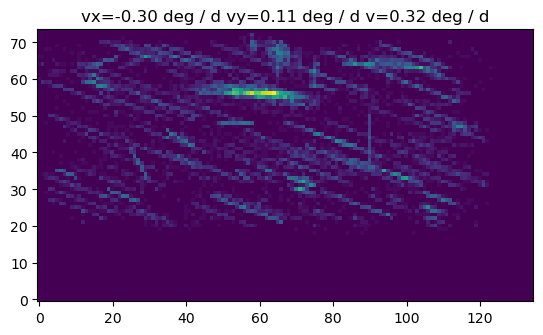

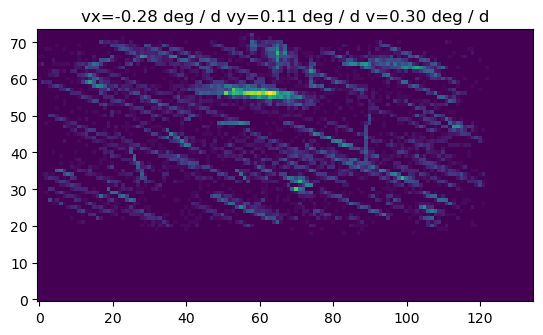

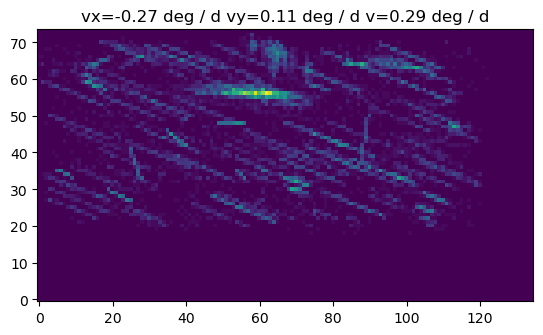

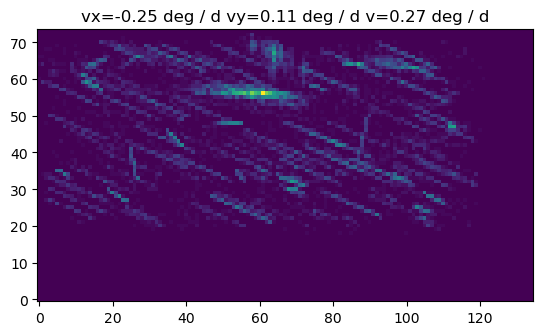

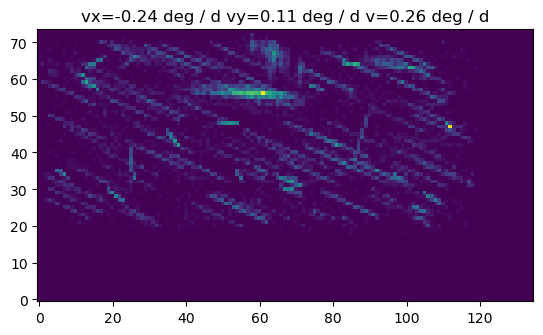

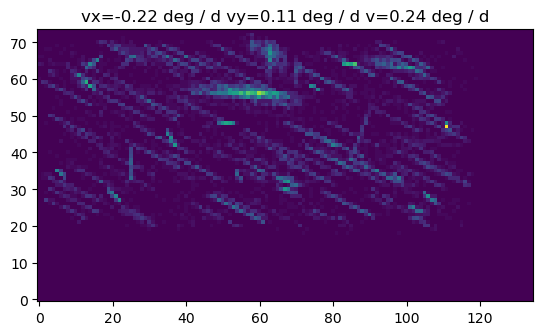

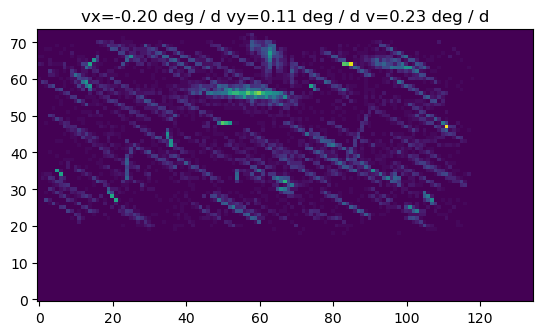

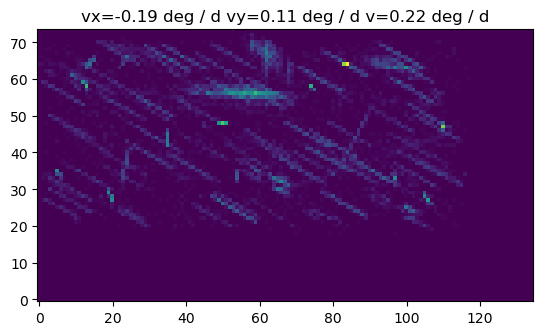

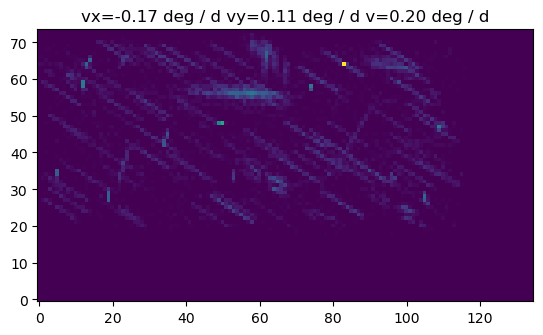

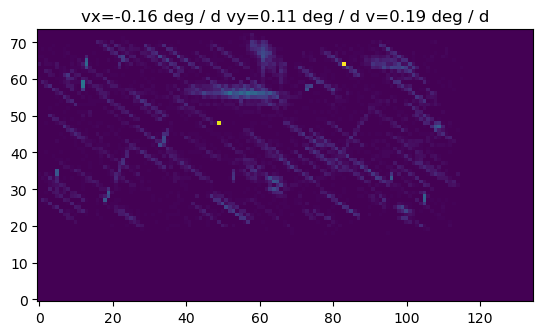

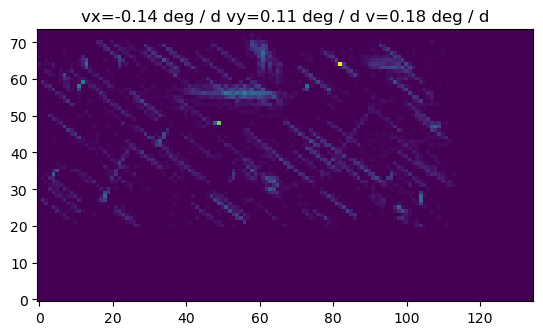

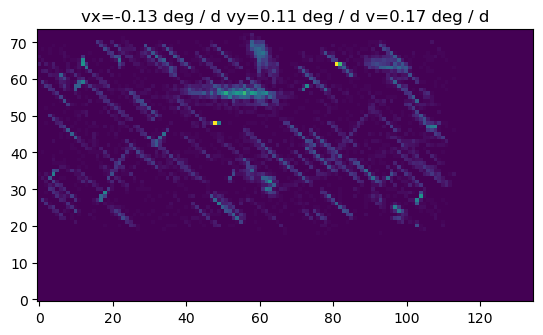

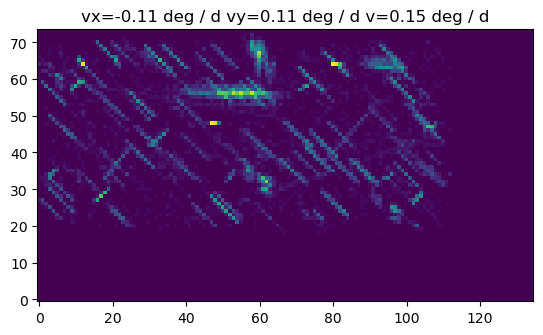

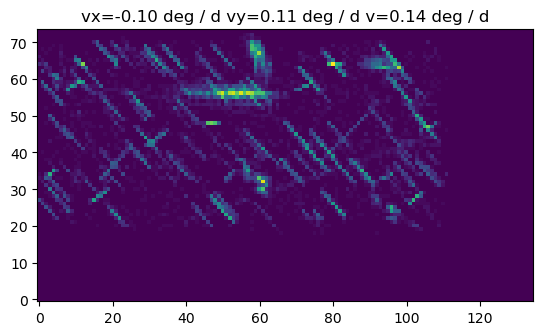

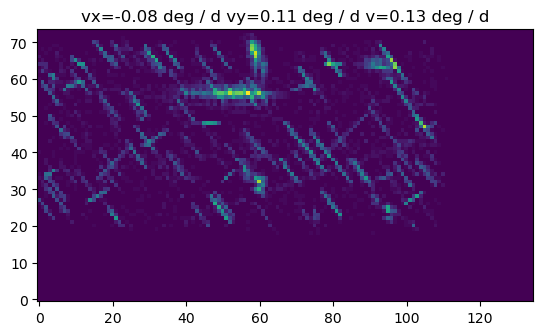

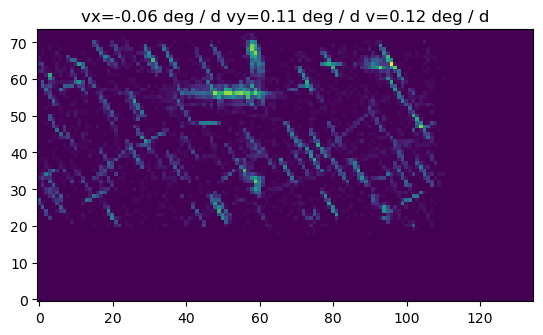

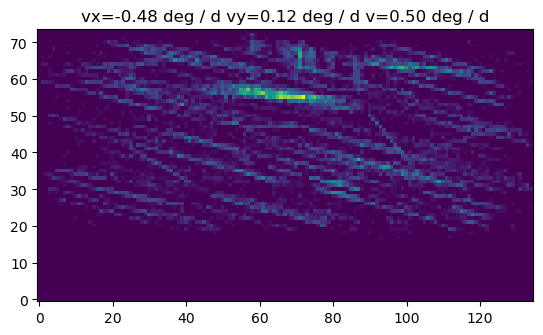

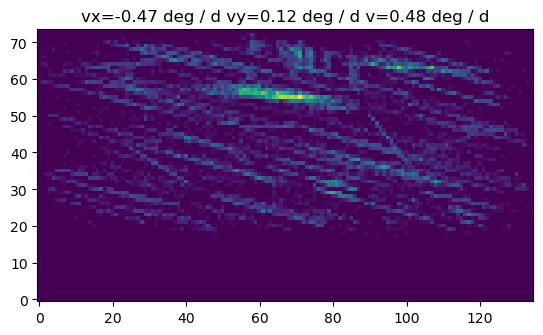

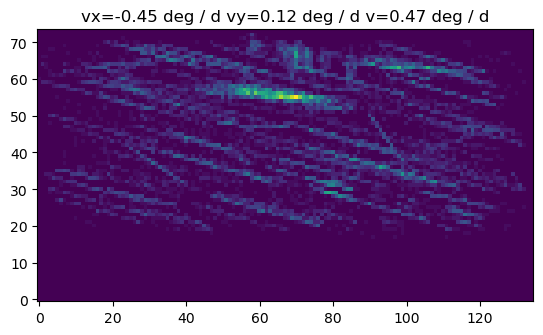

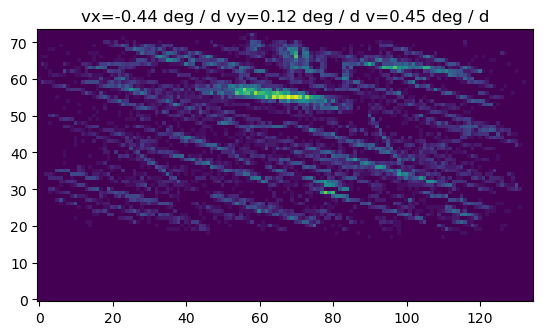

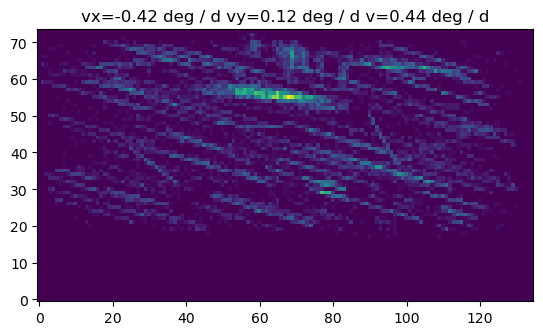

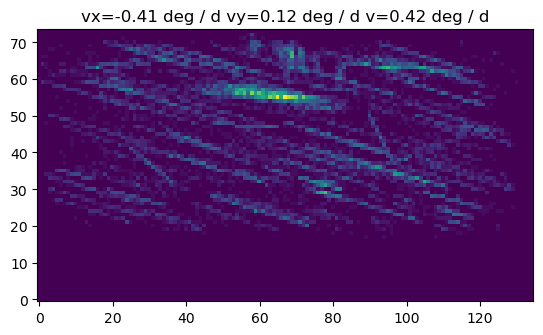

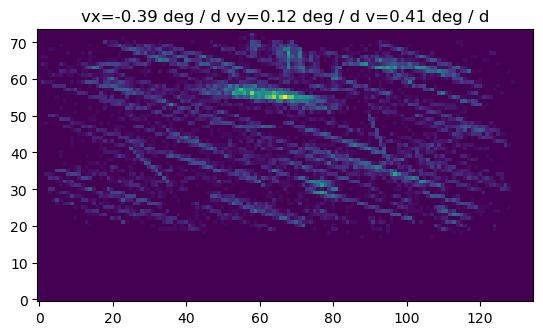

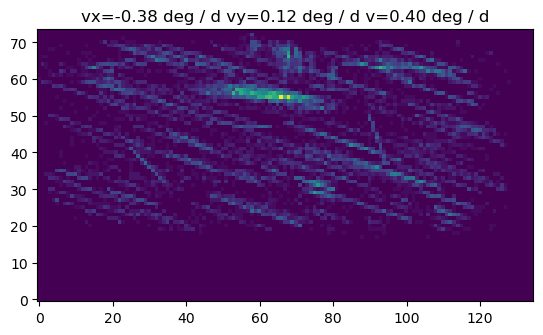

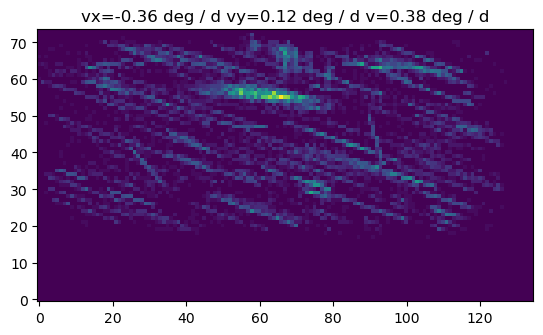

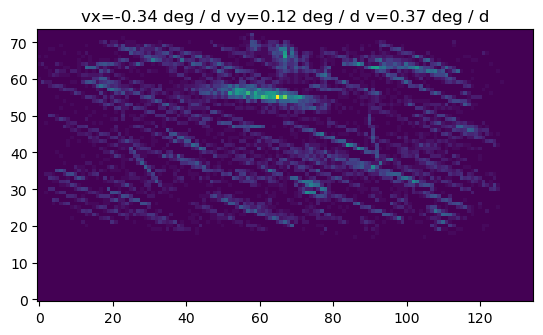

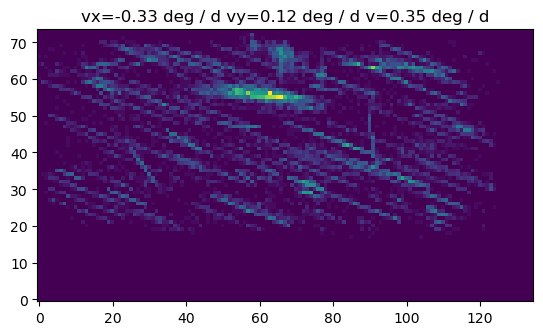

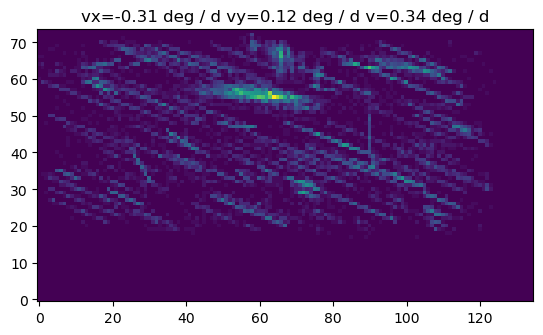

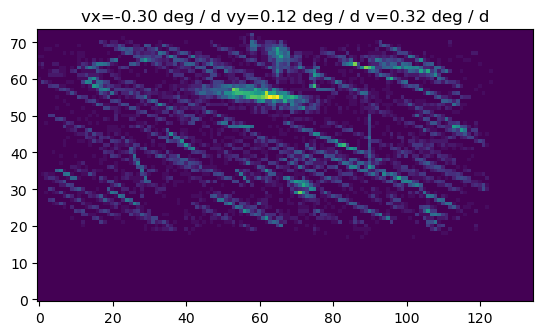


KeyboardInterrupt



In [141]:
fig = plt.figure(dpi=150)
for i in range(len(b.b)):
    d = b.b[i]
    v = (d**2).sum()**0.5
    vx = d[0]
    vy = d[1]
    plt.imshow(hough.array[i].T, origin='lower')
    plt.title(f"vx={vx:0.2f} vy={vy:0.2f} v={v:0.2f}")
    # plt.axis("off")
    # plt.colorbar()
    plt.show()

In [7]:
hough.argmax()

(179, 83, 64)

In [8]:
# %%time
clusters = Clusters()
for cluster in hough:
    votes = cluster.extra['votes']
    if votes < 25:
        break
    clusters.add(cluster)
    

In [9]:
len(clusters.clusters)

114

In [10]:
clusters.clusters[0].points[:, -1].astype(int)

array([845945, 845944, 845915, 845943, 845929, 845929, 845947, 845950,
       845950, 845935, 845939, 845916, 845967, 845949, 845961, 845961,
       845970, 845952, 845952, 845932, 845955, 845918, 845941, 845956,
       845956, 845919, 845928, 845928, 845940, 845958, 845958, 845958,
       845958, 845954, 845954, 845954, 845948, 845937, 845951, 845951,
       845951, 845926, 845926, 845953, 845959, 845959, 845921, 845921,
       845960, 845960, 845960, 845969, 845969, 845942, 845957, 845957,
       845957, 845957, 845964, 845923, 845927])

In [10]:
clusters.clusters[0].extra

{'votes': 109, 'b': 179, 'y': 64, 'x': 83}

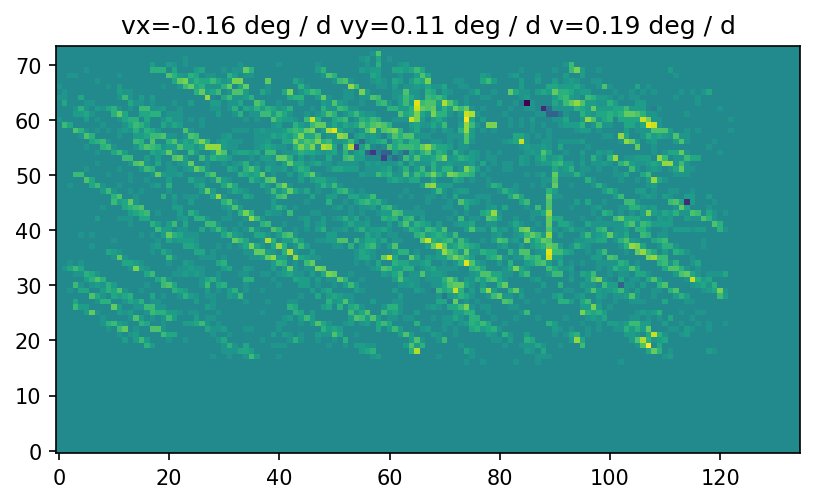

In [11]:
fig = plt.figure(dpi=150)
d = b.b[179]
v = (d**2).sum()**0.5
vx = d[0]
vy = d[1]
plt.imshow(hough.array[i].T, origin='lower')
plt.title(f"vx={vx:0.2f} vy={vy:0.2f} v={v:0.2f}")
# plt.axis("off")
# plt.colorbar()
plt.show()

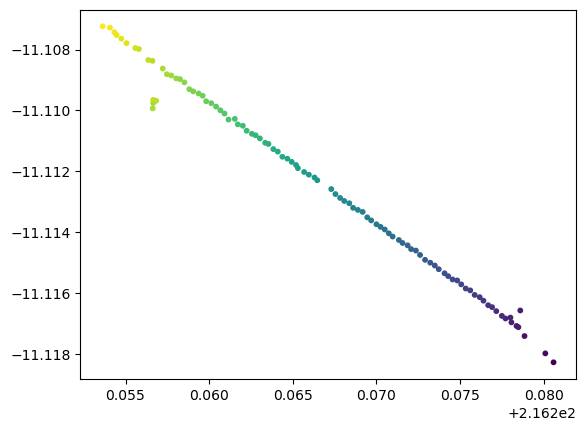

In [12]:
cluster = clusters.clusters[5]
plot_cluster(cluster, c=cluster.points[:, 2], s=10)

In [13]:
gather_threshold = 1

final = []

for cluster in clusters:
    x = cluster.points[:, 2][:, None]
    y = cluster.points[:, :2]
    result = refine(cluster)
    if result is None:
        continue
    result.alpha *= u.deg
    result.beta *= u.deg/u.day
#     plot_result(result, x, color='C0')
#     plot_cluster(cluster, c=result.outliers_r, s=10)
#     plt.title("initial")
#     plt.show()
    
    mask = gather(result, X[:, 0] * u.deg, X[:, 1] * u.deg, X[:, 2] * u.day, gather_threshold * u.arcsec)
    gathered = Cluster(X[mask], extra=dict(line=result))
    result = refine(gathered)
    if result is None:
        continue
    result.alpha *= u.deg
    result.beta *= u.deg/u.day
#     plot_result(result, x, color='C0')
#     plot_cluster(gathered, c=result.outliers_r, s=10)
#     plt.title("iter 1")
#     plt.show()
    
    mask = gather(result, X[:, 0] * u.deg, X[:, 1] * u.deg, X[:, 2] * u.day, gather_threshold * u.arcsec)
    gathered = Cluster(X[mask], extra=dict(line=result))
    result = refine(gathered)
    if result is None:
        continue
    result.alpha *= u.deg
    result.beta *= u.deg/u.day
#     plot_result(result, x, color='C0')
#     plot_cluster(gathered, c=result.outliers_r, s=10)
#     plt.title("iter 2")
#     plt.show()
    
    final.append(gathered)
    

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/epyc/projects/salad/src/salad/regression.py:86: RuntimeWarning: invalid value encountered in sqrt
  d_r = ((r @ scipy.linalg.pinvh(sigma_e) * r).sum(1))**0.5
regression returned NaN results
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/sklearn/covariance/_robust_

In [14]:
len(final)

99

In [15]:
filtered = list(
    filter(
        lambda x : filter_velocity(x, vmin=v_range[0].value, vmax=v_range[1].value),
        filter(
            lambda x : filter_n(x, n=15), 
            final
        )
    )
)
len(filtered)

17

In [16]:
filtered

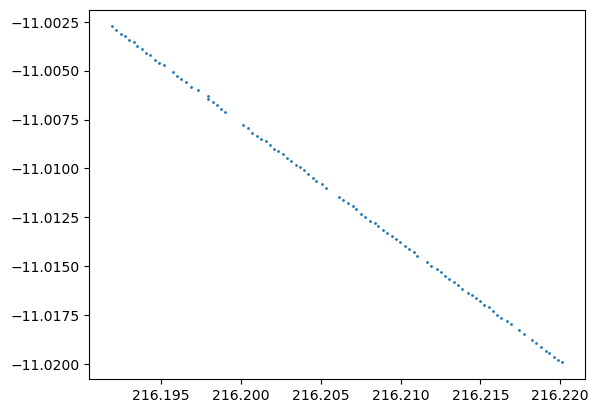

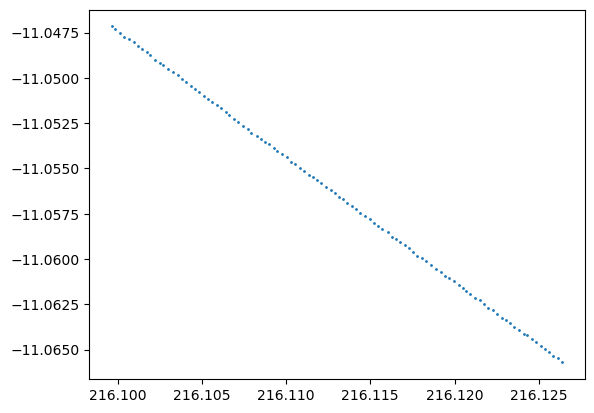

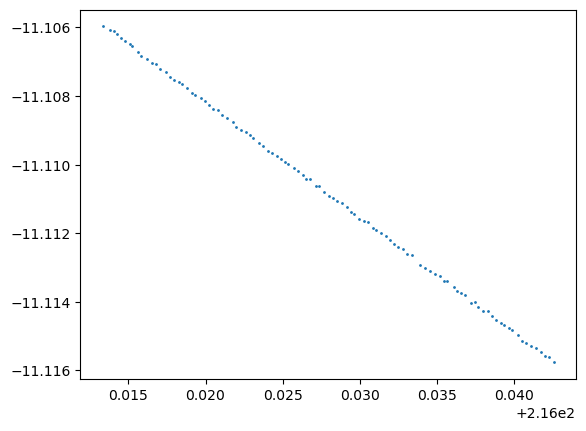

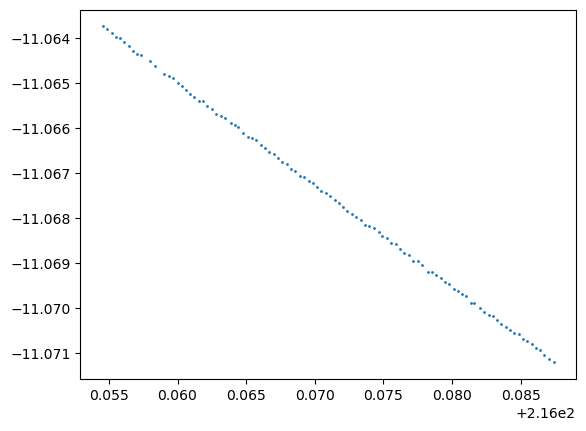

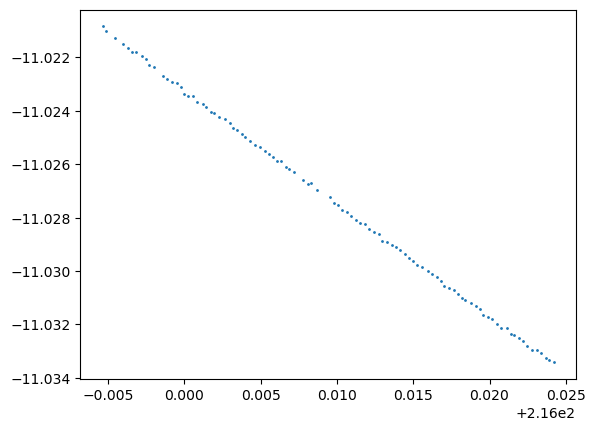

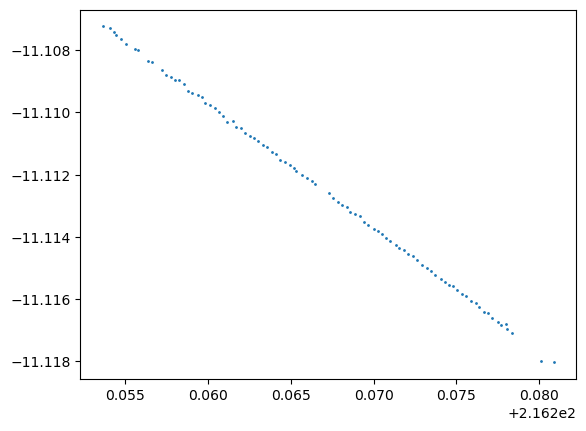

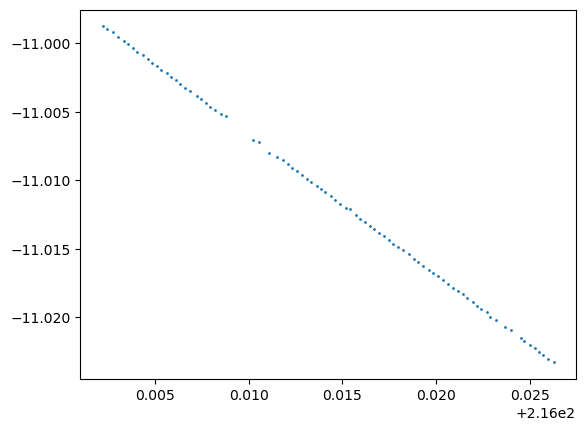

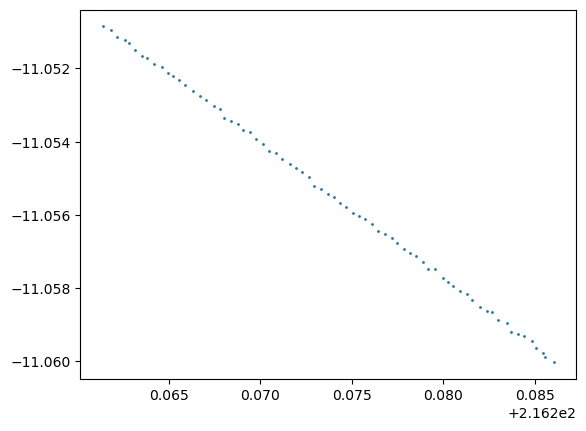

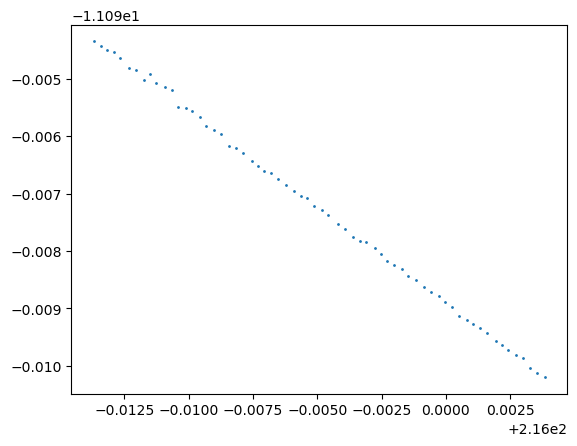

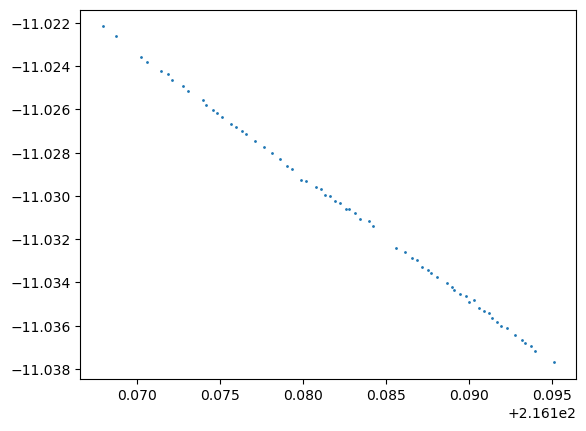

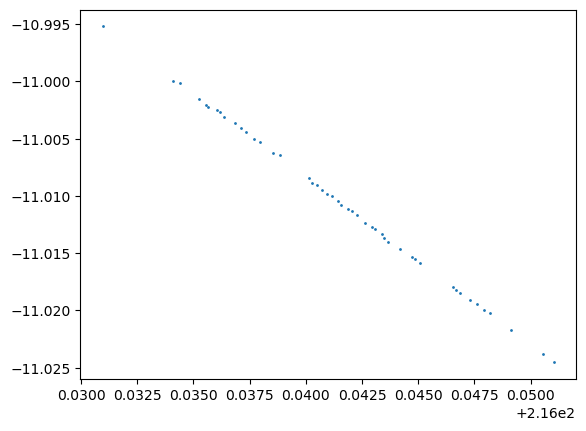

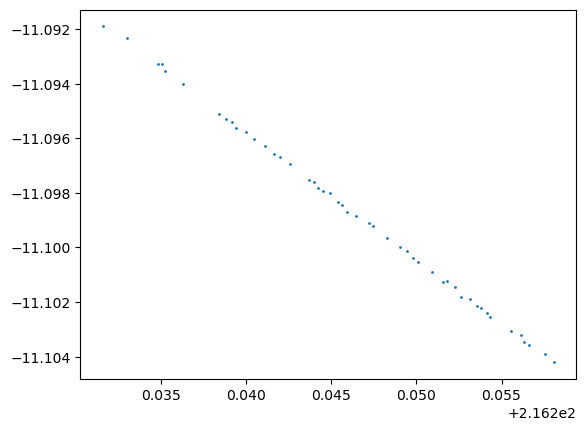

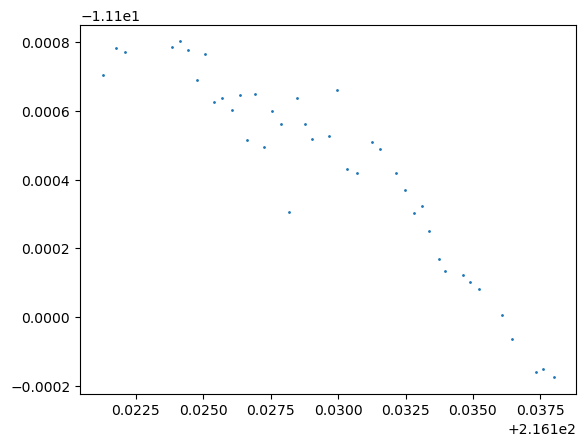

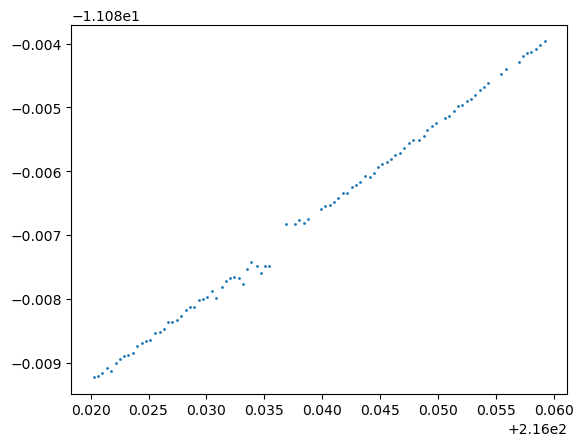

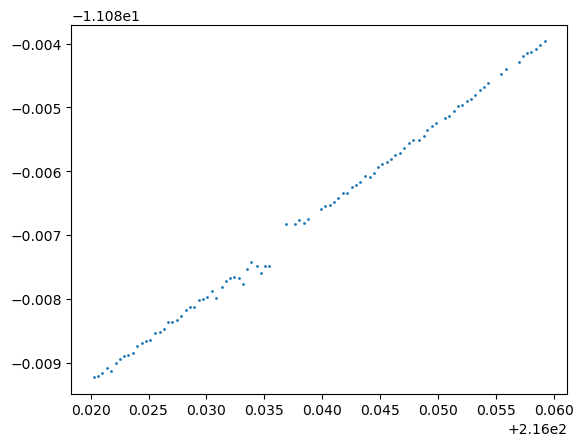

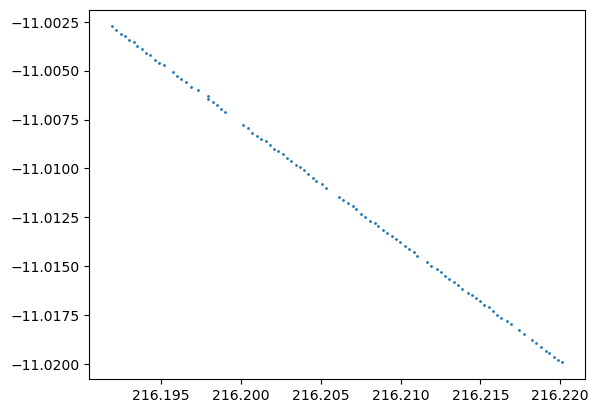

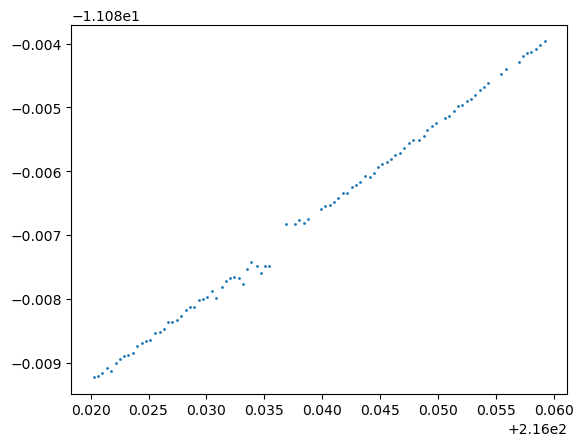

In [17]:
# fig = plt.figure(dpi=150)
for cluster in filtered:
    plot_cluster(cluster, s=1)
    plt.show()

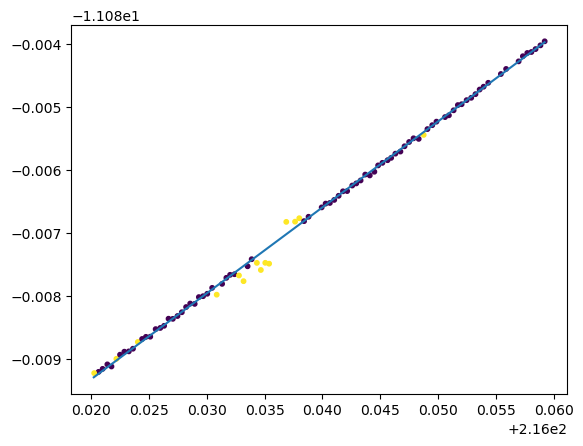

In [18]:
x = cluster.points[:, 2][:, None]
y = cluster.points[:, :2]
result = regression(x, y)
result.alpha *= u.deg
result.beta *= u.deg/u.day
plot_result(result, x, color='C0')
plot_cluster(cluster, c=result.outliers_r, s=10)

In [19]:
%%time
search.vote()

CPU times: user 594 ms, sys: 15.5 ms, total: 610 ms
Wall time: 11 ms


In [63]:
results[0][2]

(array([216.23784368, -11.21810076]),
 array([-0.17298171,  0.06060279]),
 array([False, False, False, ..., False, False, False]))

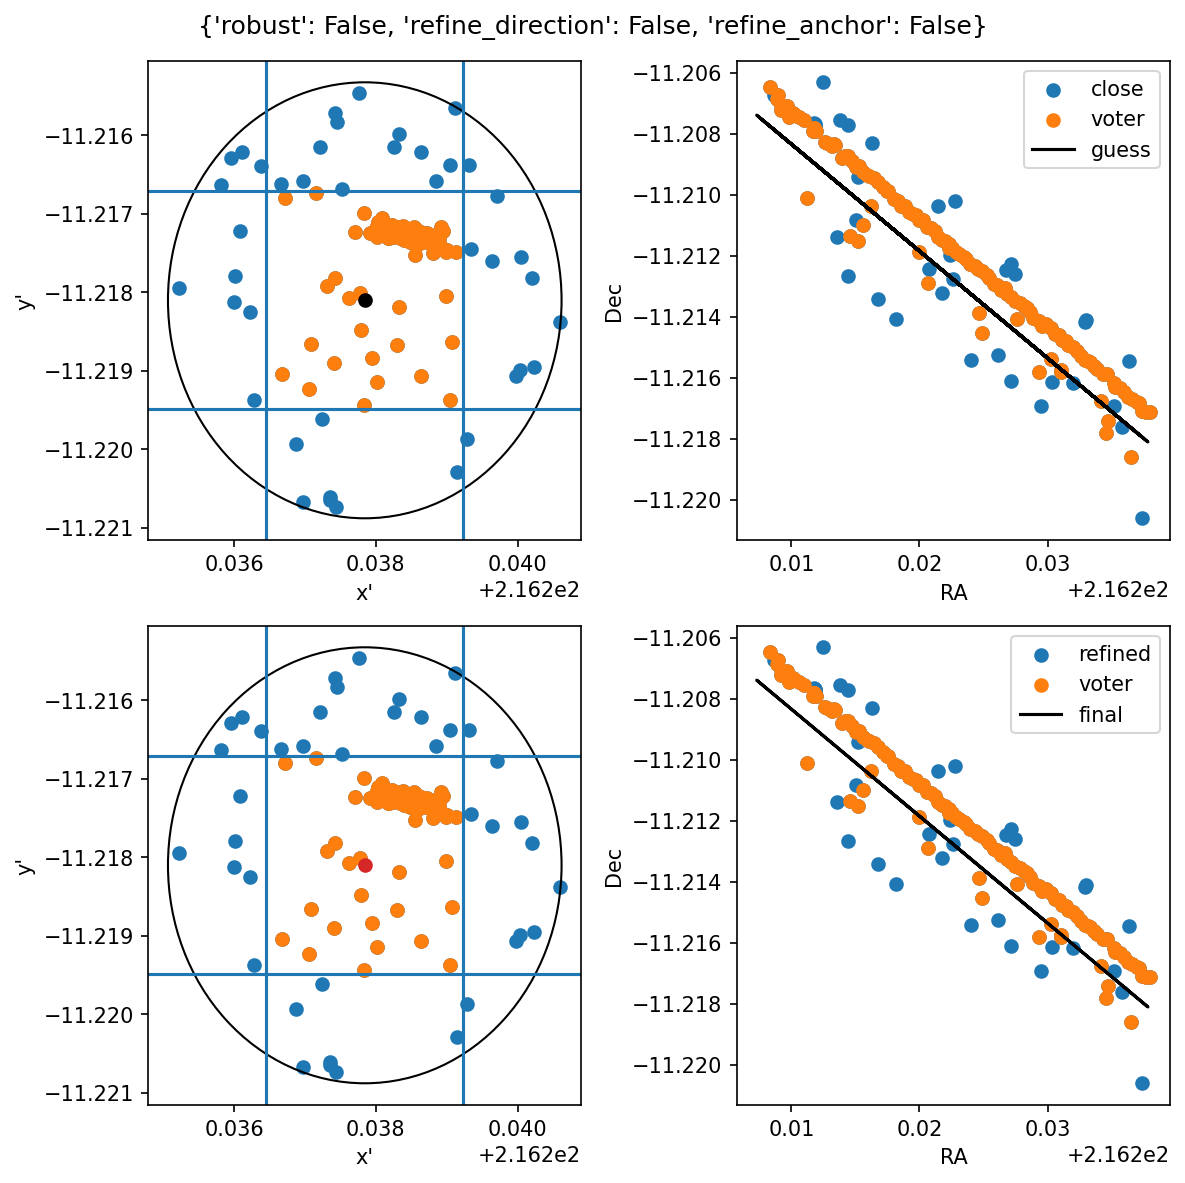

In [9]:
kwargs = dict(
    robust=False,
    refine_direction=False, 
    refine_anchor=False
)

result = search.get_top_line(**kwargs)
fig, axd = plot_result(search, result, str(kwargs))
fig

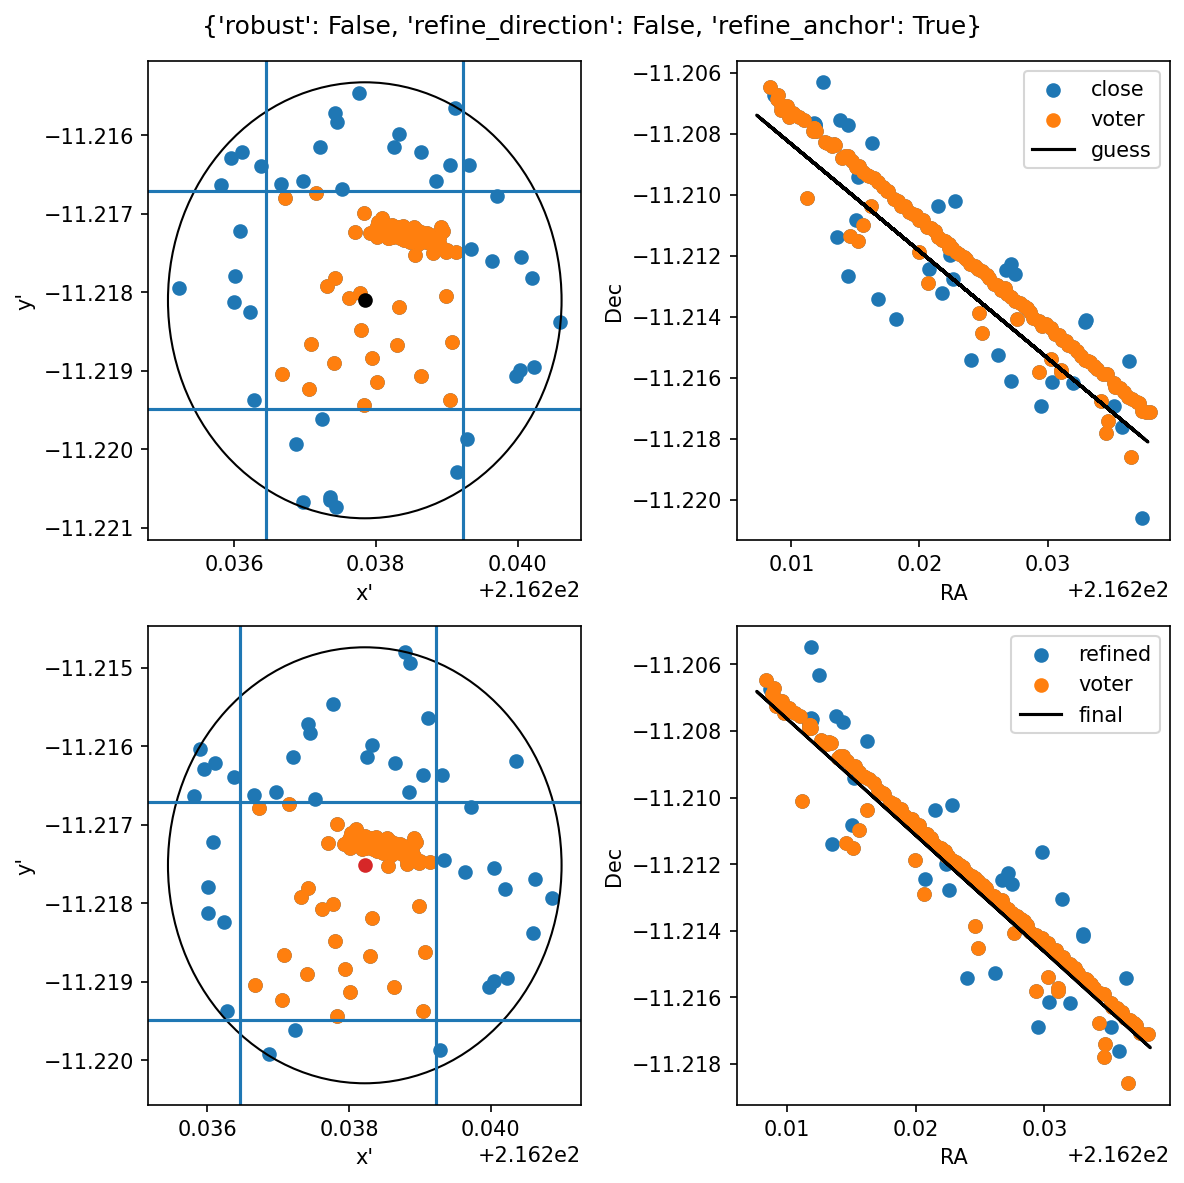

In [10]:
kwargs = dict(
    robust=False,
    refine_direction=False, 
    refine_anchor=True,
)

result = search.get_top_line(**kwargs)
fig, axd = plot_result(search, result, str(kwargs))
fig

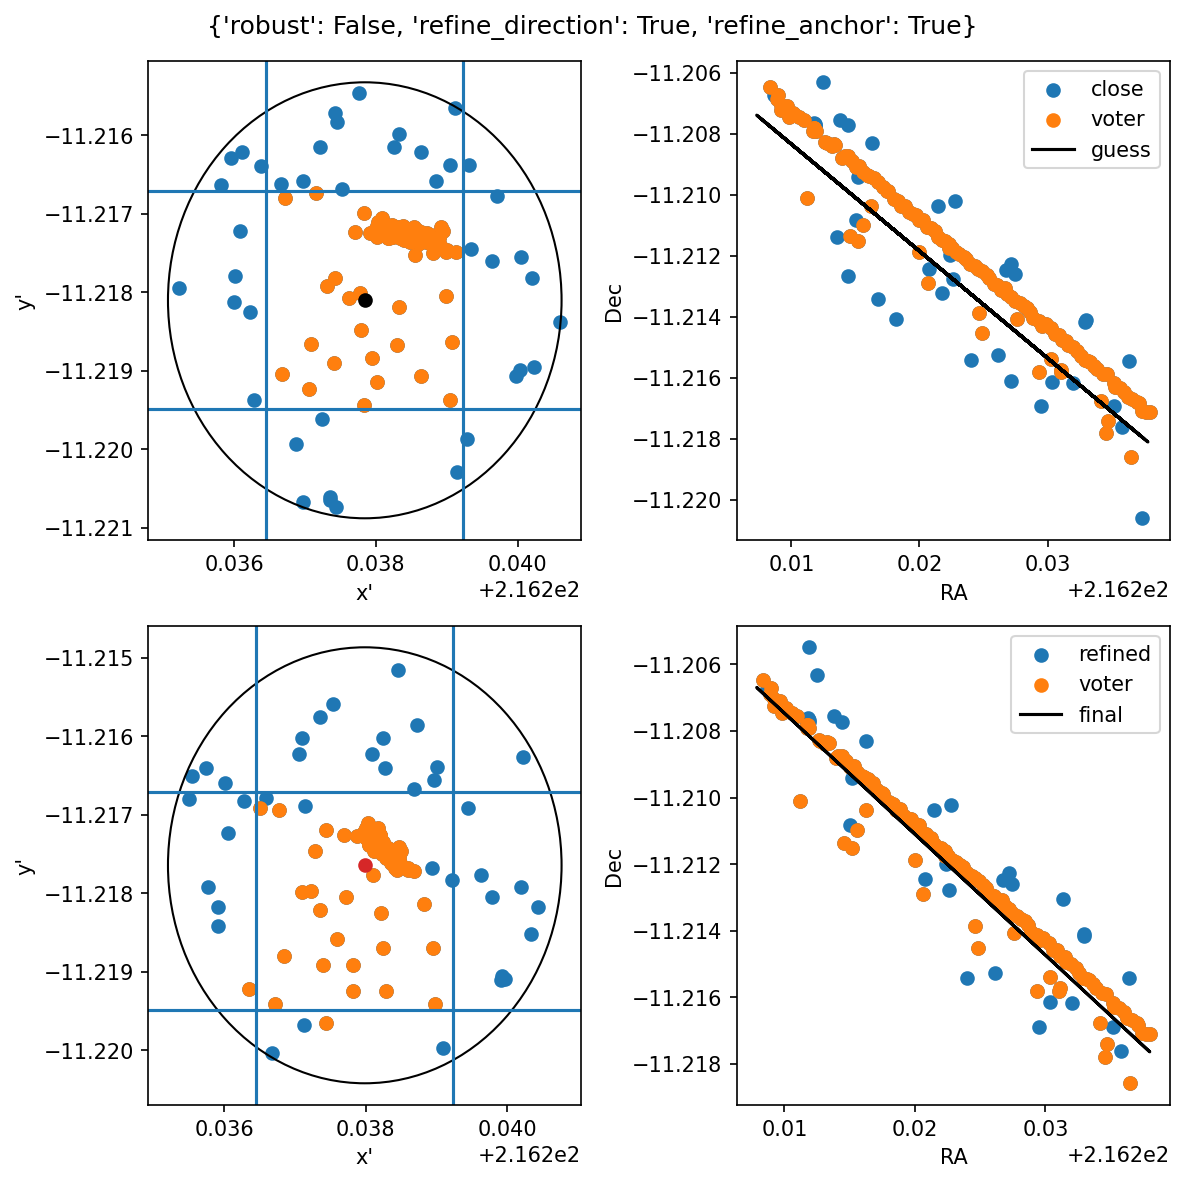

In [11]:
kwargs = dict(
    robust=False,
    refine_direction=True, 
    refine_anchor=True,
)

result = search.get_top_line(**kwargs)
fig, axd = plot_result(search, result, str(kwargs))
fig

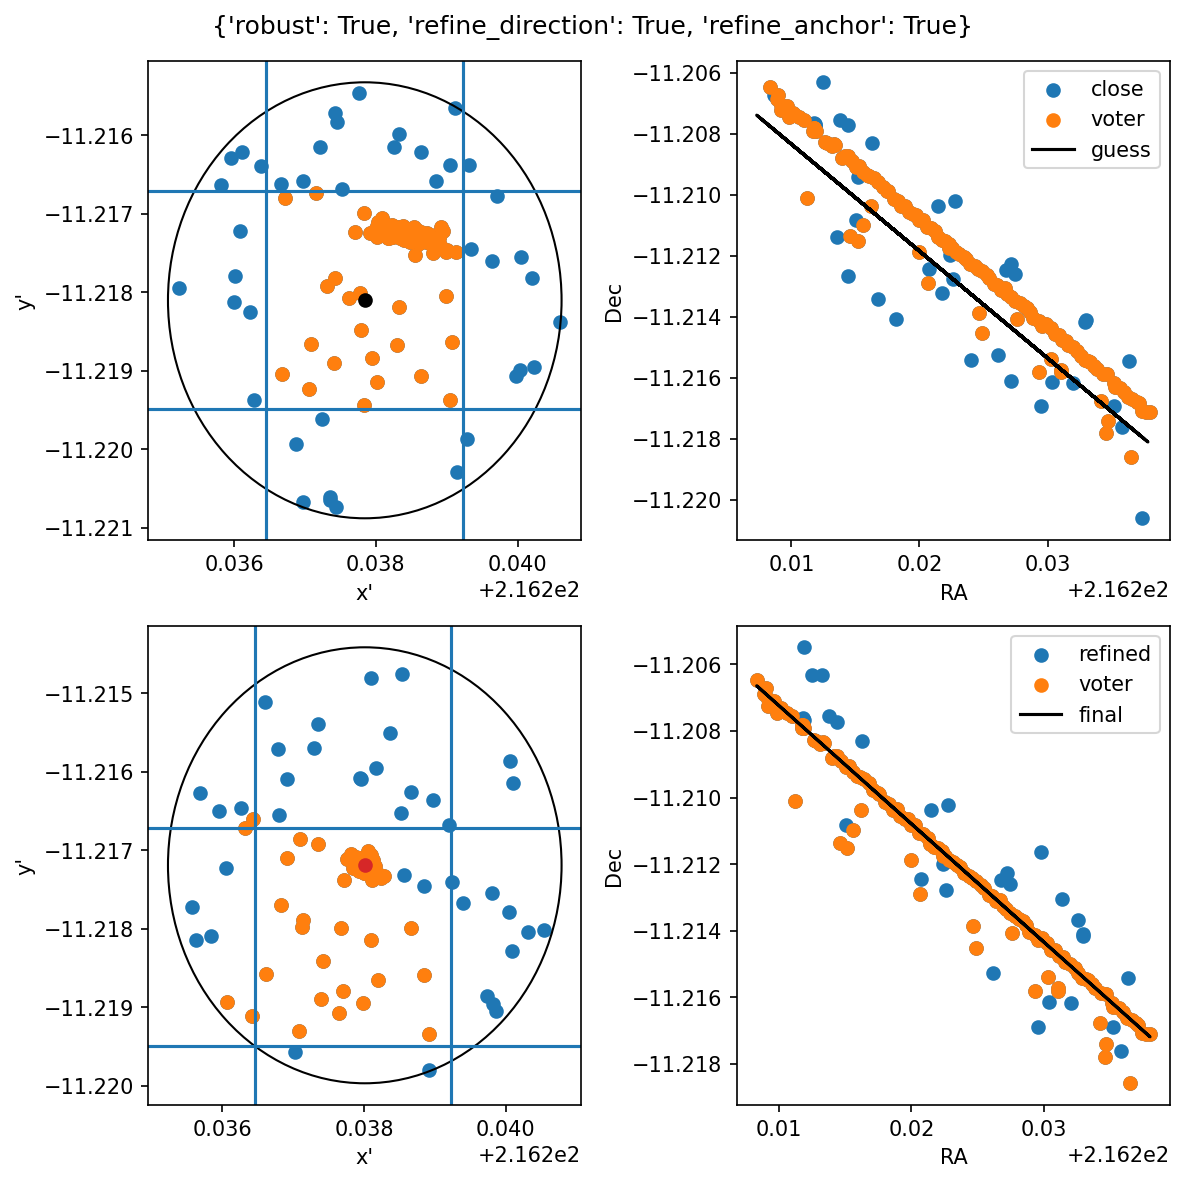

In [12]:
kwargs = dict(
    robust=True,
    refine_direction=True, 
    refine_anchor=True,
)

result = search.get_top_line(**kwargs)
fig, axd = plot_result(search, result, str(kwargs))
fig

In [23]:
results = []
while True:
    result = search.pop()
    print(result[0])
    if result[0] > 52:
        results.append(result)
    else:
        break

124
119
118
117
116
116
115
115
114
114
113
111
109
99
99
85
77
76
71
70
68
68
66
64
63
63
63
62
62
62
62
61
60
60
60
60
59
59
59
59
59
59
59
59
58
58
58
58
57
57
57
57
57
57
56
56
56
56
56
56
56
55
55
55
55
55
55
55
55
55
54
54
54
54
54
54
54
54
54
53
53
53
53
52


In [29]:
plots = []
for result in results:
    plots.append(plot_result(search, result, f"n_vote: {result[0]}"))

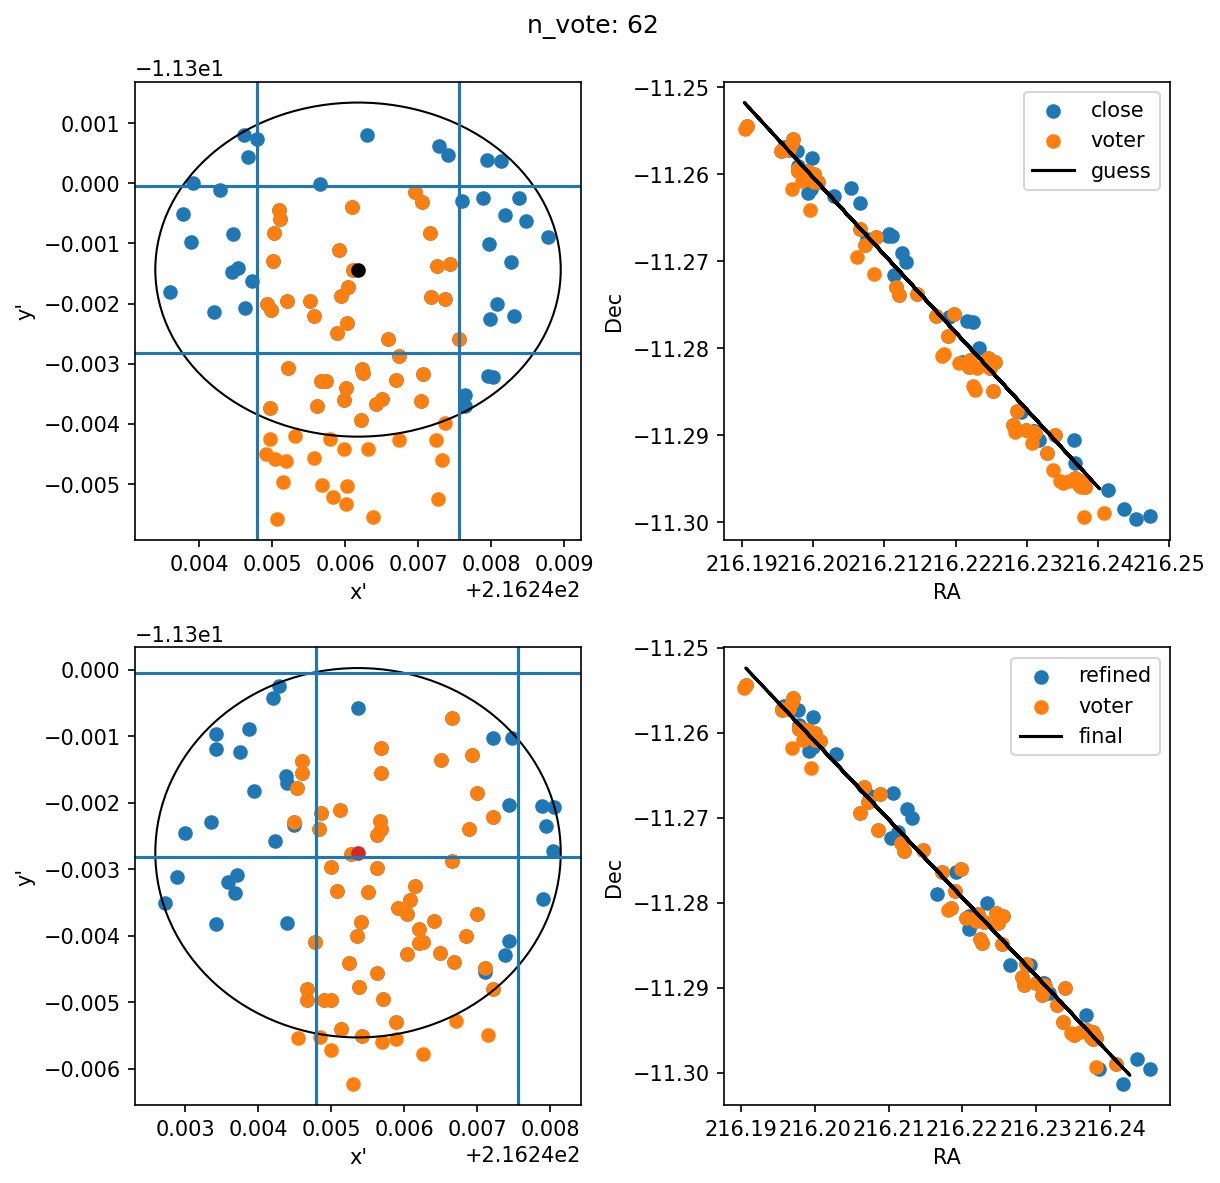

In [61]:
i = 29
fig, axd = plots[i]
fig

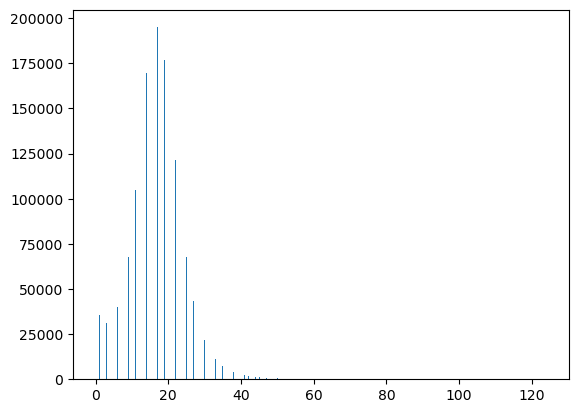

In [14]:
plt.hist(search.hough.ravel(), bins='auto')
plt.show()

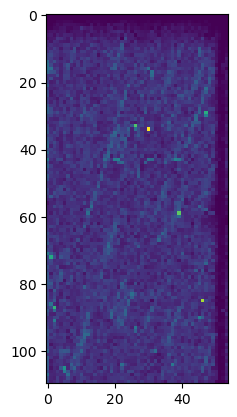

In [142]:
plt.imshow(search.hough[result[1][0]])
plt.show()

array([-0.17742734,  0.01864234])

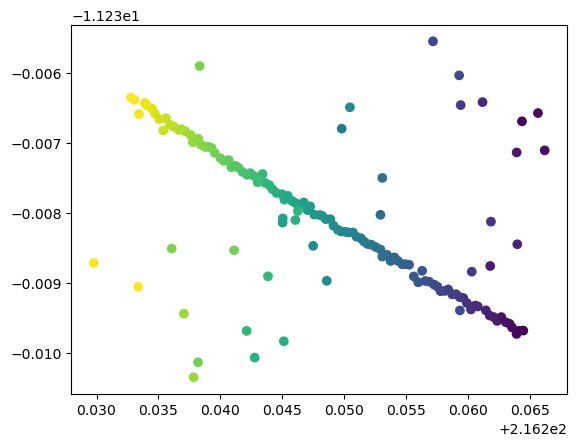

In [109]:
_p = search.X[result[3]]
plt.scatter(_p[:, 0], _p[:, 1], c=_p[:, 2])


In [115]:
v_dec, v_ra

(0.018642339235574255, -0.17742734268259483)

In [113]:
v_ra, v_dec = result[4][1]
np.arctan2(v_dec, v_ra)

3.036906490320816

In [45]:
c.X[:, 1]

array([-0.19504055, -0.19693363, -0.19487393, ..., -0.1964579 ,
       -0.19612204, -0.19567559])

In [38]:
X[0][0]*180/np.pi

216.14269724028836

In [57]:
v = 0.24304251188290005
v = 0
phi = -2.673392590944811
v_ra = v * np.cos(phi)
v_dec = v * np.sin(phi)
print(v_ra, v_dec)
b = np.array([[v_ra, v_dec]])
print(b.shape)
# X = np.array([table[c].data for c in ['coord_ra', 'coord_dec', 'time']]).T
X = c.X
X[:, 0] *= 180/np.pi
X[:, 1] *= 180/np.pi
reference_time = X[:, 2].min()
print(reference_time)

dx = 10/3600
min_x, max_x = X[:, 0].min(), X[:, 0].max()
min_y, max_y = X[:, 1].min(), X[:, 1].max()
num_x = int((max_x - min_x)/dx + 1)
num_y = int((max_y - min_y)/dx + 1)

hough = np.zeros((b.shape[0], num_x, num_y), dtype=np.int32)

M = propogate_array(X, b, X[:, 2].min())
vote_hough_X(X, b, min_x, min_y, dx, dx, reference_time, hough)

# plt.scatter(M[0, :, 0], M[0, :, 1], s=1, c=X[:, 2])
# plt.show()

-0.0 -0.0
(1, 2)
2458577.715605522


In [73]:
max_x, num_x, num_x, num_y

(216.44521217280177, 110, 110, 54)

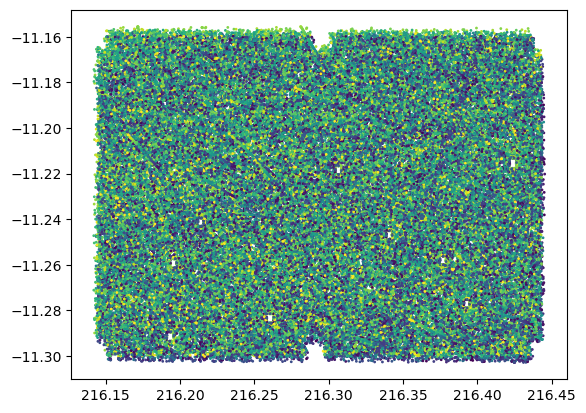

In [58]:
plt.scatter(M[0, :, 0], M[0, :, 1], c=X[:, 2], s=1)
plt.show()

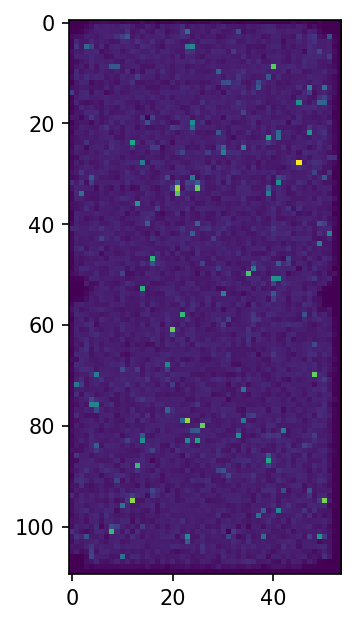

In [72]:
fig = plt.figure(dpi=150)
plt.imshow(hough[0])
plt.show()

In [55]:
hough.max()

32

In [56]:
np.where(hough == hough.max())

(array([0]), array([974]), array([417]))

IndexError: index 178 is out of bounds for axis 0 with size 1